# **Forecasting the results of sports events**

# 1) Loading and preparation of the data



In [1]:
import os
import subprocess
import logging
import sys
import warnings
import requests
import pandas as pd
from bs4 import BeautifulSoup

CSV_FILE = "matches_raw.csv"
DROPBOX_URL = (
    "https://www.dropbox.com/scl/fi/zk0zb58etdun5opkkucux/"
    "matches_raw.csv?rlkey=nu08nqynhu4odrjslvbf790jb&st=eycqa32t&dl=1"
)  # dl=1 → direct download
USE_DROPBOX = False      # ← flip to True if you prefer the Dropbox snapshot

SEASON_URLS = {
    "2024-2025": "https://soccer365.ru/competitions/19/results/",
    "2023-2024": "https://soccer365.ru/competitions/19/2023-2024/results/",
    "2022-2023": "https://soccer365.ru/competitions/19/2022-2023/results/",
    "2021-2022": "https://soccer365.ru/competitions/19/2021-2022/results/",
    "2020-2021": "https://soccer365.ru/competitions/19/2020-2021/results/",
    "2019-2020": "https://soccer365.ru/competitions/19/2019-2020/results/",
    "2018-2019": "https://soccer365.ru/competitions/19/2018-2019/results/",
}

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/89.0.4389.114 Safari/537.36"
    )
}

# dual logger / printer
logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO,
    format="[{levelname:^7s} {asctime}] {message}",
    datefmt="%H:%M:%S",
    style="{",
)
logg = logging.getLogger("ucl_loader")
log = lambda m, lvl="info": (getattr(logg, lvl)(m), print(m))[1]


# helpers
def get_soup(url: str) -> BeautifulSoup:
    log(f"GET  {url}")
    r = requests.get(url, headers=HEADERS, timeout=20)
    r.raise_for_status()
    if "Лига чемпионов УЕФА" not in r.text:
        raise ValueError("Unexpected page content (competition title not found).")
    return BeautifulSoup(r.text, "lxml")


def extract_match_links(results_url: str) -> list[str]:
    """Return sorted list of unique match URLs from a season results page."""
    soup = get_soup(results_url)
    base = "https://soccer365.ru"
    return sorted(
        {
            base + a["href"]
            for a in soup.select("a.game_link[href]")
            if "/games/" in a["href"]
        }
    )


def parse_match(url: str) -> dict:
    soup = get_soup(url)
    l, r = soup.select_one("div.live_game.left"), soup.select_one(
        "div.live_game.right"
    )
    return dict(
        URL=url,
        HomeTeam=l.a.text.strip(),
        HomeGoals=int(l.span.text.strip()),
        AwayTeam=r.a.text.strip(),
        AwayGoals=int(r.span.text.strip()),
    )


def scrape_matches() -> pd.DataFrame:
    """Scrape all seasons defined in SEASON_URLS and return DataFrame."""
    rows = []
    for season, url in SEASON_URLS.items():
        log(f"\n════ {season} ════")
        for i, match_url in enumerate(extract_match_links(url), 1):
            log(f"[{i:03}] {match_url}")
            try:
                rows.append(parse_match(match_url))
            except Exception as e:
                warnings.warn(f"{match_url} -> {e}")
    df = pd.DataFrame(rows)
    log(f"✓  Scrape finished: {len(df)} matches collected.")
    return df


def download_csv(dropbox_url: str = DROPBOX_URL, dest: str = CSV_FILE) -> None:
    """Download CSV file from Dropbox."""
    log("Downloading CSV from Dropbox …")
    try:
        subprocess.run(["wget", "-q", "-O", dest, dropbox_url], check=True)
        log("✓  CSV downloaded.")
    except Exception as e:
        raise RuntimeError(f"Failed to download CSV: {e}")


def load_matches_from_csv(csv_path: str = CSV_FILE) -> pd.DataFrame:
    """Load matches DataFrame from local CSV."""
    if not os.path.isfile(csv_path):
        raise FileNotFoundError(f"{csv_path} not found.")
    df = pd.read_csv(csv_path)
    log(f"✓  Loaded {len(df)} matches from {csv_path}")
    return df


def save_matches_to_csv(df: pd.DataFrame, csv_path: str = CSV_FILE) -> None:
    df.to_csv(csv_path, index=False)
    log(f"✓  Saved {len(df)} matches to {csv_path}")


try:
    if USE_DROPBOX:
        if not os.path.isfile(CSV_FILE):
            download_csv()
        matches_raw = load_matches_from_csv()
    else:
        matches_raw = scrape_matches()
        save_matches_to_csv(matches_raw)
except Exception as exc:
    log(f"⚠  An error occurred: {exc}", "error")
    raise

# Keep only essential columns
matches = matches_raw[["HomeTeam", "AwayTeam", "HomeGoals", "AwayGoals"]]
log(f"\nTotal matches in DataFrame: {len(matches)}")

matches.head()



════ 2024-2025 ════
GET  https://soccer365.ru/competitions/19/results/
[001] https://soccer365.ru/games/2084464/
GET  https://soccer365.ru/games/2084464/
[002] https://soccer365.ru/games/2084465/
GET  https://soccer365.ru/games/2084465/
[003] https://soccer365.ru/games/2084466/
GET  https://soccer365.ru/games/2084466/
[004] https://soccer365.ru/games/2084467/
GET  https://soccer365.ru/games/2084467/
[005] https://soccer365.ru/games/2084468/
GET  https://soccer365.ru/games/2084468/
[006] https://soccer365.ru/games/2084469/
GET  https://soccer365.ru/games/2084469/
[007] https://soccer365.ru/games/2084470/
GET  https://soccer365.ru/games/2084470/
[008] https://soccer365.ru/games/2084471/
GET  https://soccer365.ru/games/2084471/
[009] https://soccer365.ru/games/2084472/
GET  https://soccer365.ru/games/2084472/
[010] https://soccer365.ru/games/2084473/
GET  https://soccer365.ru/games/2084473/
[011] https://soccer365.ru/games/2084474/
GET  https://soccer365.ru/games/2084474/
[012] https://s

<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/15693506/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[064] https://soccer365.ru/games/15693507/
GET  https://soccer365.ru/games/15693507/
[065] https://soccer365.ru/games/15693508/
GET  https://soccer365.ru/games/15693508/
[066] https://soccer365.ru/games/15693509/
GET  https://soccer365.ru/games/15693509/
[067] https://soccer365.ru/games/15693510/
GET  https://soccer365.ru/games/15693510/
[068] https://soccer365.ru/games/15693511/
GET  https://soccer365.ru/games/15693511/
[069] https://soccer365.ru/games/15693512/
GET  https://soccer365.ru/games/15693512/
[070] https://soccer365.ru/games/15693513/
GET  https://soccer365.ru/games/15693513/
[071] https://soccer365.ru/games/15693514/
GET  https://soccer365.ru/games/15693514/
[072] https://soccer365.ru/games/15693515/
GET  https://soccer365.ru/games/15693515/
[073] https://soccer365.ru/games/15693516/
GET  https://soccer365.ru/games/15693516/


<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/15693516/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[074] https://soccer365.ru/games/15693517/
GET  https://soccer365.ru/games/15693517/
[075] https://soccer365.ru/games/15693518/
GET  https://soccer365.ru/games/15693518/
[076] https://soccer365.ru/games/15693519/
GET  https://soccer365.ru/games/15693519/
[077] https://soccer365.ru/games/15693520/
GET  https://soccer365.ru/games/15693520/
[078] https://soccer365.ru/games/15693521/
GET  https://soccer365.ru/games/15693521/
[079] https://soccer365.ru/games/15693522/
GET  https://soccer365.ru/games/15693522/
[080] https://soccer365.ru/games/15693523/
GET  https://soccer365.ru/games/15693523/
[081] https://soccer365.ru/games/15693524/
GET  https://soccer365.ru/games/15693524/
[082] https://soccer365.ru/games/15693525/
GET  https://soccer365.ru/games/15693525/
[083] https://soccer365.ru/games/15693526/
GET  https://soccer365.ru/games/15693526/
[084] https://soccer365.ru/games/15693527/
GET  https://soccer365.ru/games/15693527/
[085] https://soccer365.ru/games/15693528/
GET  https://soccer365

<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/15327264/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[108] https://soccer365.ru/games/15327265/
GET  https://soccer365.ru/games/15327265/
[109] https://soccer365.ru/games/15327266/
GET  https://soccer365.ru/games/15327266/
[110] https://soccer365.ru/games/15327267/
GET  https://soccer365.ru/games/15327267/
[111] https://soccer365.ru/games/15327268/
GET  https://soccer365.ru/games/15327268/
[112] https://soccer365.ru/games/15327269/
GET  https://soccer365.ru/games/15327269/
[113] https://soccer365.ru/games/15327270/
GET  https://soccer365.ru/games/15327270/
[114] https://soccer365.ru/games/15327271/
GET  https://soccer365.ru/games/15327271/
[115] https://soccer365.ru/games/15327272/
GET  https://soccer365.ru/games/15327272/
[116] https://soccer365.ru/games/15327273/
GET  https://soccer365.ru/games/15327273/
[117] https://soccer365.ru/games/15327274/
GET  https://soccer365.ru/games/15327274/
[118] https://soccer365.ru/games/15327275/
GET  https://soccer365.ru/games/15327275/
[119] https://soccer365.ru/games/15327276/
GET  https://soccer365

<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/15327293/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[137] https://soccer365.ru/games/15327294/
GET  https://soccer365.ru/games/15327294/
[138] https://soccer365.ru/games/15327295/
GET  https://soccer365.ru/games/15327295/
[139] https://soccer365.ru/games/15327296/
GET  https://soccer365.ru/games/15327296/
[140] https://soccer365.ru/games/15327297/
GET  https://soccer365.ru/games/15327297/
[141] https://soccer365.ru/games/15327298/
GET  https://soccer365.ru/games/15327298/
[142] https://soccer365.ru/games/15327299/
GET  https://soccer365.ru/games/15327299/
[143] https://soccer365.ru/games/15327300/
GET  https://soccer365.ru/games/15327300/
[144] https://soccer365.ru/games/15327301/
GET  https://soccer365.ru/games/15327301/
[145] https://soccer365.ru/games/15327302/
GET  https://soccer365.ru/games/15327302/


<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/15327302/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[146] https://soccer365.ru/games/15327303/
GET  https://soccer365.ru/games/15327303/
[147] https://soccer365.ru/games/15327304/
GET  https://soccer365.ru/games/15327304/
[148] https://soccer365.ru/games/15327305/
GET  https://soccer365.ru/games/15327305/
[149] https://soccer365.ru/games/15327306/
GET  https://soccer365.ru/games/15327306/
[150] https://soccer365.ru/games/15327307/
GET  https://soccer365.ru/games/15327307/
[151] https://soccer365.ru/games/15327308/
GET  https://soccer365.ru/games/15327308/
[152] https://soccer365.ru/games/15327309/
GET  https://soccer365.ru/games/15327309/
[153] https://soccer365.ru/games/15327310/
GET  https://soccer365.ru/games/15327310/
[154] https://soccer365.ru/games/15327311/
GET  https://soccer365.ru/games/15327311/
[155] https://soccer365.ru/games/15327312/
GET  https://soccer365.ru/games/15327312/
[156] https://soccer365.ru/games/15327313/
GET  https://soccer365.ru/games/15327313/
[157] https://soccer365.ru/games/15327314/
GET  https://soccer365

<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/15327334/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[178] https://soccer365.ru/games/15327335/
GET  https://soccer365.ru/games/15327335/
[179] https://soccer365.ru/games/15327336/
GET  https://soccer365.ru/games/15327336/
[180] https://soccer365.ru/games/15327337/
GET  https://soccer365.ru/games/15327337/
[181] https://soccer365.ru/games/15327338/
GET  https://soccer365.ru/games/15327338/
[182] https://soccer365.ru/games/15327339/
GET  https://soccer365.ru/games/15327339/
[183] https://soccer365.ru/games/15327340/
GET  https://soccer365.ru/games/15327340/
[184] https://soccer365.ru/games/15327341/
GET  https://soccer365.ru/games/15327341/
[185] https://soccer365.ru/games/15327342/
GET  https://soccer365.ru/games/15327342/
[186] https://soccer365.ru/games/15327343/
GET  https://soccer365.ru/games/15327343/
[187] https://soccer365.ru/games/15327344/
GET  https://soccer365.ru/games/15327344/
[188] https://soccer365.ru/games/15327345/
GET  https://soccer365.ru/games/15327345/
[189] https://soccer365.ru/games/15327346/
GET  https://soccer365

<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/15133789/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[046] https://soccer365.ru/games/15133790/
GET  https://soccer365.ru/games/15133790/
[047] https://soccer365.ru/games/15133791/
GET  https://soccer365.ru/games/15133791/
[048] https://soccer365.ru/games/15133792/
GET  https://soccer365.ru/games/15133792/
[049] https://soccer365.ru/games/15133793/
GET  https://soccer365.ru/games/15133793/
[050] https://soccer365.ru/games/15133794/
GET  https://soccer365.ru/games/15133794/
[051] https://soccer365.ru/games/15133795/
GET  https://soccer365.ru/games/15133795/


<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/15133795/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[052] https://soccer365.ru/games/15133796/
GET  https://soccer365.ru/games/15133796/
[053] https://soccer365.ru/games/15133797/
GET  https://soccer365.ru/games/15133797/
[054] https://soccer365.ru/games/15133798/
GET  https://soccer365.ru/games/15133798/
[055] https://soccer365.ru/games/15133799/
GET  https://soccer365.ru/games/15133799/
[056] https://soccer365.ru/games/15133800/
GET  https://soccer365.ru/games/15133800/
[057] https://soccer365.ru/games/15133801/
GET  https://soccer365.ru/games/15133801/
[058] https://soccer365.ru/games/15133802/
GET  https://soccer365.ru/games/15133802/
[059] https://soccer365.ru/games/15133803/
GET  https://soccer365.ru/games/15133803/
[060] https://soccer365.ru/games/15133804/
GET  https://soccer365.ru/games/15133804/
[061] https://soccer365.ru/games/15133805/
GET  https://soccer365.ru/games/15133805/
[062] https://soccer365.ru/games/15133806/
GET  https://soccer365.ru/games/15133806/
[063] https://soccer365.ru/games/15133807/
GET  https://soccer365

<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/15133828/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[085] https://soccer365.ru/games/15133829/
GET  https://soccer365.ru/games/15133829/
[086] https://soccer365.ru/games/15133830/
GET  https://soccer365.ru/games/15133830/
[087] https://soccer365.ru/games/15133831/
GET  https://soccer365.ru/games/15133831/
[088] https://soccer365.ru/games/15133832/
GET  https://soccer365.ru/games/15133832/
[089] https://soccer365.ru/games/15133833/
GET  https://soccer365.ru/games/15133833/
[090] https://soccer365.ru/games/15133834/
GET  https://soccer365.ru/games/15133834/
[091] https://soccer365.ru/games/15133835/
GET  https://soccer365.ru/games/15133835/
[092] https://soccer365.ru/games/15133836/
GET  https://soccer365.ru/games/15133836/
[093] https://soccer365.ru/games/15133837/
GET  https://soccer365.ru/games/15133837/
[094] https://soccer365.ru/games/15133838/
GET  https://soccer365.ru/games/15133838/
[095] https://soccer365.ru/games/15133839/
GET  https://soccer365.ru/games/15133839/
[096] https://soccer365.ru/games/15133840/
GET  https://soccer365

<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/15133882/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[139] https://soccer365.ru/games/15133883/
GET  https://soccer365.ru/games/15133883/
[140] https://soccer365.ru/games/15133884/
GET  https://soccer365.ru/games/15133884/
[141] https://soccer365.ru/games/15133885/
GET  https://soccer365.ru/games/15133885/
[142] https://soccer365.ru/games/15133886/
GET  https://soccer365.ru/games/15133886/
[143] https://soccer365.ru/games/15133887/
GET  https://soccer365.ru/games/15133887/
[144] https://soccer365.ru/games/15133888/
GET  https://soccer365.ru/games/15133888/
[145] https://soccer365.ru/games/15133889/
GET  https://soccer365.ru/games/15133889/
[146] https://soccer365.ru/games/15133890/
GET  https://soccer365.ru/games/15133890/
[147] https://soccer365.ru/games/15133891/
GET  https://soccer365.ru/games/15133891/
[148] https://soccer365.ru/games/15133892/
GET  https://soccer365.ru/games/15133892/
[149] https://soccer365.ru/games/15133893/
GET  https://soccer365.ru/games/15133893/
[150] https://soccer365.ru/games/15133894/
GET  https://soccer365

<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/14899189/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[111] https://soccer365.ru/games/14899190/
GET  https://soccer365.ru/games/14899190/
[112] https://soccer365.ru/games/14899191/
GET  https://soccer365.ru/games/14899191/
[113] https://soccer365.ru/games/14899192/
GET  https://soccer365.ru/games/14899192/
[114] https://soccer365.ru/games/14899193/
GET  https://soccer365.ru/games/14899193/
[115] https://soccer365.ru/games/14899194/
GET  https://soccer365.ru/games/14899194/
[116] https://soccer365.ru/games/14899195/
GET  https://soccer365.ru/games/14899195/
[117] https://soccer365.ru/games/14899196/
GET  https://soccer365.ru/games/14899196/
[118] https://soccer365.ru/games/14899197/
GET  https://soccer365.ru/games/14899197/
[119] https://soccer365.ru/games/14899198/
GET  https://soccer365.ru/games/14899198/
[120] https://soccer365.ru/games/14899199/
GET  https://soccer365.ru/games/14899199/
[121] https://soccer365.ru/games/14899200/
GET  https://soccer365.ru/games/14899200/
[122] https://soccer365.ru/games/14899201/
GET  https://soccer365

<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/14899253/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[175] https://soccer365.ru/games/14899254/
GET  https://soccer365.ru/games/14899254/
[176] https://soccer365.ru/games/14899255/
GET  https://soccer365.ru/games/14899255/
[177] https://soccer365.ru/games/14899256/
GET  https://soccer365.ru/games/14899256/
[178] https://soccer365.ru/games/14899257/
GET  https://soccer365.ru/games/14899257/
[179] https://soccer365.ru/games/14899258/
GET  https://soccer365.ru/games/14899258/
[180] https://soccer365.ru/games/14899259/
GET  https://soccer365.ru/games/14899259/
[181] https://soccer365.ru/games/14899260/
GET  https://soccer365.ru/games/14899260/
[182] https://soccer365.ru/games/14899261/
GET  https://soccer365.ru/games/14899261/
[183] https://soccer365.ru/games/14899262/
GET  https://soccer365.ru/games/14899262/
[184] https://soccer365.ru/games/14899263/
GET  https://soccer365.ru/games/14899263/
[185] https://soccer365.ru/games/14899264/
GET  https://soccer365.ru/games/14899264/
[186] https://soccer365.ru/games/14899265/
GET  https://soccer365

<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/14111933/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[103] https://soccer365.ru/games/14111934/
GET  https://soccer365.ru/games/14111934/
[104] https://soccer365.ru/games/14111935/
GET  https://soccer365.ru/games/14111935/
[105] https://soccer365.ru/games/14111936/
GET  https://soccer365.ru/games/14111936/
[106] https://soccer365.ru/games/14111937/
GET  https://soccer365.ru/games/14111937/
[107] https://soccer365.ru/games/14111938/
GET  https://soccer365.ru/games/14111938/
[108] https://soccer365.ru/games/14111939/
GET  https://soccer365.ru/games/14111939/
[109] https://soccer365.ru/games/14111940/
GET  https://soccer365.ru/games/14111940/
[110] https://soccer365.ru/games/14111941/
GET  https://soccer365.ru/games/14111941/
[111] https://soccer365.ru/games/14111942/
GET  https://soccer365.ru/games/14111942/
[112] https://soccer365.ru/games/14111943/
GET  https://soccer365.ru/games/14111943/
[113] https://soccer365.ru/games/14111944/
GET  https://soccer365.ru/games/14111944/
[114] https://soccer365.ru/games/14111945/
GET  https://soccer365

<ipython-input-1-ca1923894879>:94: UserWarning: https://soccer365.ru/games/14111989/ -> invalid literal for int() with base 10: '-'
  warnings.warn(f"{match_url} -> {e}")


[159] https://soccer365.ru/games/14111990/
GET  https://soccer365.ru/games/14111990/
[160] https://soccer365.ru/games/14111991/
GET  https://soccer365.ru/games/14111991/
[161] https://soccer365.ru/games/14111992/
GET  https://soccer365.ru/games/14111992/
[162] https://soccer365.ru/games/14111993/
GET  https://soccer365.ru/games/14111993/
[163] https://soccer365.ru/games/14111994/
GET  https://soccer365.ru/games/14111994/
[164] https://soccer365.ru/games/14111995/
GET  https://soccer365.ru/games/14111995/
[165] https://soccer365.ru/games/14111996/
GET  https://soccer365.ru/games/14111996/
[166] https://soccer365.ru/games/14111997/
GET  https://soccer365.ru/games/14111997/
[167] https://soccer365.ru/games/14111998/
GET  https://soccer365.ru/games/14111998/
[168] https://soccer365.ru/games/14111999/
GET  https://soccer365.ru/games/14111999/
[169] https://soccer365.ru/games/14112000/
GET  https://soccer365.ru/games/14112000/
[170] https://soccer365.ru/games/14112001/
GET  https://soccer365

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Борац БЛ,Эгнатия,1,0
1,Хамрун Спартанс,Линкольн Ред Импс,0,1
2,УЭ Санта-Колома,Балканы,1,2
3,Флора,Целе,0,5
4,КИ Клаксвик,Дифферданж 03,2,0


In [2]:
matches_raw

,URL,HomeTeam,HomeGoals,AwayTeam,AwayGoals
0,https://soccer365.ru/games/2084464/,Борац БЛ,1,Эгнатия,0
1,https://soccer365.ru/games/2084465/,Хамрун Спартанс,0,Линкольн Ред Импс,1
2,https://soccer365.ru/games/2084466/,УЭ Санта-Колома,1,Балканы,2
3,https://soccer365.ru/games/2084467/,Флора,0,Целе,5
4,https://soccer365.ru/games/2084468/,КИ Клаксвик,2,Дифферданж 03,0
...,...,...,...,...,...
1509,https://soccer365.ru/games/14112043/,Аякс,2,Тоттенхэм,3
1510,https://soccer365.ru/games/14112044/,Ливерпуль,4,Барселона,0
1511,https://soccer365.ru/games/14112045/,Аякс,2,Тоттенхэм,3
1512,https://soccer365.ru/games/14112046/,Ливерпуль,4,Барселона,0


# 2) Modelling and comparing of 3 chosen models

In [3]:
import numpy as np, pandas as pd, warnings, importlib, subprocess, sys
import statsmodels.formula.api as smf, statsmodels.api as sm
from scipy.stats import poisson
import xgboost as xgb
import ipywidgets as widgets
from IPython.display import display, clear_output


if importlib.util.find_spec("lightgbm") is None:
    print("Installing LightGBM … (one-time, 20-30 s)")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "lightgbm"])
import lightgbm as lgb


req = {"HomeTeam","AwayTeam","HomeGoals","AwayGoals"}
if not req.issubset(matches.columns):
    raise ValueError(f"`matches` missing {req - set(matches.columns)}")


gld = pd.concat([
    matches[["HomeTeam","AwayTeam","HomeGoals"]]
        .assign(home=1)
        .rename(columns={"HomeTeam":"team","AwayTeam":"opponent","HomeGoals":"goals"}),
    matches[["AwayTeam","HomeTeam","AwayGoals"]]
        .assign(home=0)
        .rename(columns={"AwayTeam":"team","HomeTeam":"opponent","AwayGoals":"goals"})
])
pois_mdl = smf.glm("goals ~ home + team + opponent", data=gld,
                   family=sm.families.Poisson()).fit()

def predict_pois(home, away, max_g=8):
    mu_h = pois_mdl.predict({"team":[home],"opponent":[away],"home":[1]})[0]
    mu_a = pois_mdl.predict({"team":[away],"opponent":[home],"home":[0]})[0]
    return _prob_table(mu_h, mu_a, max_g)

X_oh = pd.get_dummies(matches[["HomeTeam","AwayTeam"]]); X_oh["home"]=1
dmat = xgb.DMatrix(X_oh)
params = dict(objective="count:poisson", eval_metric="poisson-nloglik",
              eta=.05, max_depth=5, subsample=.8, colsample_bytree=.8)
xgb_h = xgb.train(params, xgb.DMatrix(X_oh, matches.HomeGoals), 600, verbose_eval=False)
xgb_a = xgb.train(params, xgb.DMatrix(X_oh, matches.AwayGoals), 600, verbose_eval=False)

def predict_xgb(home, away, max_g=8):
    vec = _vectorize(home, away, X_oh.columns)
    mu_h = float(xgb_h.predict(xgb.DMatrix(vec))[0])
    mu_a = float(xgb_a.predict(xgb.DMatrix(vec))[0])
    return _prob_table(mu_h, mu_a, max_g)


lgb_params = dict(objective="poisson", metric="poisson", learning_rate=.05,
                  max_depth=5, num_leaves=31, subsample=.8, colsample_bytree=.8,
                  verbose=-1)
lgb_h = lgb.train(lgb_params,
                  lgb.Dataset(X_oh, matches.HomeGoals),
                  num_boost_round=600)
lgb_a = lgb.train(lgb_params,
                  lgb.Dataset(X_oh, matches.AwayGoals),
                  num_boost_round=600)

def predict_lgb(home, away, max_g=8):
    vec = _vectorize(home, away, X_oh.columns)
    mu_h = float(lgb_h.predict(vec)[0])
    mu_a = float(lgb_a.predict(vec)[0])
    return _prob_table(mu_h, mu_a, max_g)


def _vectorize(home, away, cols):
    v = pd.get_dummies(pd.DataFrame({"HomeTeam":[home], "AwayTeam":[away]}))
    v["home"] = 1
    return v.reindex(columns=cols, fill_value=0)

def _prob_table(mu_h, mu_a, max_g):
    pmf_h = poisson.pmf(np.arange(max_g+1)[:,None], mu=mu_h)
    pmf_a = poisson.pmf(np.arange(max_g+1)[None,:],  mu=mu_a)
    mat   = pmf_h*pmf_a
    hw,dw,aw = np.tril(mat,-1).sum(), np.diag(mat).sum(), np.triu(mat,1).sum()
    exp_h = int(round((mat.sum(1)*np.arange(mat.shape[0])).sum()))
    exp_a = int(round((mat.sum(0)*np.arange(mat.shape[1])).sum()))
    return dict(HG=exp_h, AG=exp_a, HW=hw, D=dw, AW=aw)


clubs = sorted(matches.HomeTeam.unique())
home_dd  = widgets.Dropdown(options=clubs, description="Home:")
away_dd  = widgets.Dropdown(options=clubs, description="Away:")
model_dd = widgets.ToggleButtons(
    options=[("Poisson GLM","pois"), ("XGBoost Poisson","xgb"), ("LightGBM Poisson","lgb")],
    description="Model:")
out = widgets.Output()

def refresh(_=None):
    with out:
        clear_output()
        h, a, tag = home_dd.value, away_dd.value, model_dd.value
        if h == a: print("⚠ choose two different clubs"); return
        pred = {"pois":predict_pois,
                "xgb": predict_xgb,
                "lgb": predict_lgb}[tag](h,a)

        winner = h if pred["HW"]==max(pred["HW"],pred["D"],pred["AW"]) else (
                 a if pred["AW"]==max(pred["HW"],pred["D"],pred["AW"]) else "Draw")

        display(pd.DataFrame({
            "HomeTeam":[h], "AwayTeam":[a],
            "HomeGoals":[pred["HG"]], "AwayGoals":[pred["AG"]],
            "HomeWinProb":[round(pred["HW"],6)],
            "DrawProb":[round(pred["D"],6)],
            "HomeLossProb":[round(pred["AW"],6)],
            "Winner":[winner],
            "Model":[model_dd.label]
        }))

for w in (home_dd, away_dd, model_dd):
    w.observe(refresh, names="value")

display(widgets.HBox([home_dd, away_dd, model_dd]), out)
refresh()


Output()

# 3) Comparison of models' quality by different metrcis to choose the BEST one

In [4]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, log_loss)
import numpy as np, pandas as pd

def probs_poisson(row):           # returns [P(H), P(D), P(A)]
    pr = predict_pois(row.HomeTeam, row.AwayTeam)
    return np.array([pr["HW"], pr["D"], pr["AW"]])

def probs_xgb(row):
    pr = predict_xgb(row.HomeTeam, row.AwayTeam)
    return np.array([pr["HW"], pr["D"], pr["AW"]])

def probs_lgb(row):
    pr = predict_lgb(row.HomeTeam, row.AwayTeam)
    return np.array([pr["HW"], pr["D"], pr["AW"]])

PROB_FUNCS = {"Poisson GLM": probs_poisson,
              "XGBoost Poisson": probs_xgb,
              "LightGBM Poisson": probs_lgb}


y_true = np.where(matches.HomeGoals > matches.AwayGoals, 0,
         np.where(matches.HomeGoals < matches.AwayGoals, 2, 1))

rows = []
for name, fn in PROB_FUNCS.items():
    probs = np.vstack(matches.apply(fn, axis=1).to_numpy())
    y_pred = probs.argmax(axis=1)

    rows.append({
        "Model"     : name,
        "Accuracy"  : round(accuracy_score(y_true, y_pred), 3),
        "Precision" : round(precision_score(y_true, y_pred, average="macro"), 3),
        "Recall"    : round(recall_score(y_true, y_pred, average="macro"), 3),
        "F1-score"  : round(f1_score(y_true, y_pred, average="macro"), 3),
        "Log-loss"  : round(log_loss(y_true, probs), 3)
    })

score_table = pd.DataFrame(rows).set_index("Model").sort_values("F1-score", ascending=False)
display(score_table)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


KeyboardInterrupt: 

# 4) Visualisation

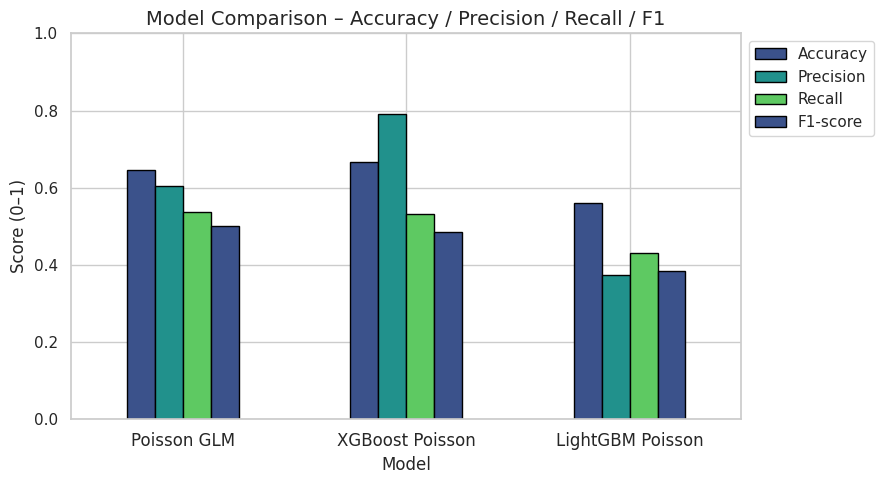

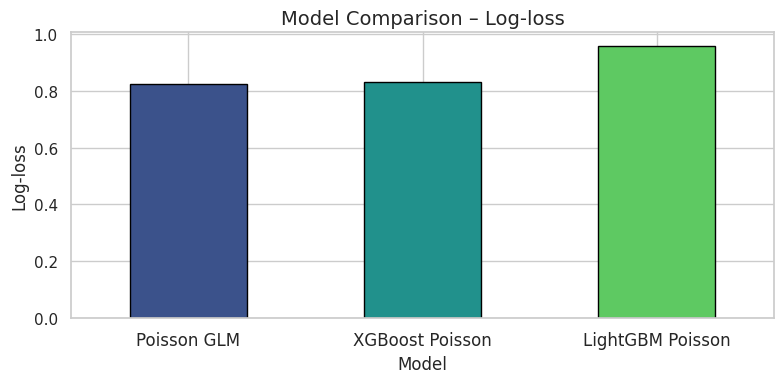

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
palette = sns.color_palette("viridis", n_colors=len(score_table))

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

# graph 1: Comparison Accuracy / Precision / Recall / F1
fig1, ax1 = plt.subplots(figsize=(9, 5))
score_table[metrics].plot(kind="bar", ax=ax1, color=palette, edgecolor='black')

ax1.set_title("Model Comparison – Accuracy / Precision / Recall / F1", fontsize=14)
ax1.set_ylabel("Score (0–1)", fontsize=12)
ax1.set_ylim(0, 1)
ax1.set_xticklabels(score_table.index, rotation=0, fontsize=12)

ax1.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=11)
plt.tight_layout()
plt.show()

# graph 2: Comparison Log-loss
fig2, ax2 = plt.subplots(figsize=(8, 4))
score_table["Log-loss"].plot(kind="bar", ax=ax2, color=palette, edgecolor='black')

ax2.set_title("Model Comparison – Log-loss", fontsize=14)
ax2.set_ylabel("Log-loss", fontsize=12)
ax2.set_xticklabels(score_table.index, rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

# **Working with news to discover whether the was an influence of SMM on the teams' mood and its' results**

This code analyzes how well sentiment from news headlines correlates with actual football match outcomes, using a comparison approach that can later include both VADER and BERT models.

# 1) VADER

In [5]:
!pip install feedparser

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=ae24dddc0376099f956070e6188fb7f3963bb61ae12188dde29ea2f44ad3b0ba
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


This code collects recent news headlines about selected football clubs from Google News RSS feeds, analyzes the sentiment of each article using the VADER lexicon from the NLTK library, and stores the results in a structured CSV file. It supports loading a pre-saved dataset from Dropbox or scraping fresh data if no snapshot is available. All results are cached to Google Drive for later use. The final output is a dataframe containing team names, article titles, dates, links, sentiment scores, and text snippets — ready for further analysis on how media coverage might influence team performance.

In [6]:
from google.colab import drive
drive.mount("/content/drive", force_remount=False)
import os, sys, time, logging, html, re, requests
import datetime as dt
import feedparser
import pandas as pd
import nltk

nltk.download("vader_lexicon", quiet=True)
from nltk.sentiment import SentimentIntensityAnalyzer

NEWS_CACHE_PATH = "/content/drive/MyDrive/football_cache/team_news.csv"
os.makedirs(os.path.dirname(NEWS_CACHE_PATH), exist_ok=True)

DROPBOX_URL = (
    "https://www.dropbox.com/scl/fi/abcd1234abcd/team_news.csv?rlkey=xyz&dl=1"
)
USE_DROPBOX = False   # ← flip to True to load the Dropbox snapshot instead

# A list of clubs
if "matches" in globals():
    CLUBS = sorted(set(matches.HomeTeam) | set(matches.AwayTeam))
else:
    CLUBS = [
        "Real Madrid",
        "Manchester City",
        "Bayern Munich",
        "Paris Saint-Germain",
        "FC Barcelona",
    ]  # fallback sample – edit as needed

# logger
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO,
                    format="[{levelname:^7s} {asctime}] {message}",
                    datefmt="%H:%M:%S", style='{')
logg = logging.getLogger("team_news")
log  = lambda m, lvl="info": (getattr(logg, lvl)(m), print(m))[1]

# utility functions
def download_csv(dropbox_url: str = DROPBOX_URL, dest: str = NEWS_CACHE_PATH) -> None:
    """Download a CSV snapshot from Dropbox."""
    log("Downloading CSV from Dropbox …")
    import subprocess
    try:
        subprocess.run(["wget", "-q", "-O", dest, dropbox_url], check=True)
        log("✓  CSV downloaded.")
    except Exception as e:
        raise RuntimeError(f"Failed to download CSV: {e}")

def load_news_from_csv(csv_path: str = NEWS_CACHE_PATH) -> pd.DataFrame:
    if not os.path.isfile(csv_path):
        raise FileNotFoundError(f"{csv_path} not found.")
    df = pd.read_csv(csv_path, parse_dates=["date"])
    log(f"✓  Loaded {len(df)} headlines from {csv_path}")
    return df

def fetch_google_news(team: str, n_articles: int = 30, pause: float = 0.4) -> list[dict]:
    """Fetch recent headlines for one team from Google News RSS."""
    log(f"Fetching Google-News for {team} …")
    url = (
        "https://news.google.com/rss/search?"
        f"q={requests.utils.quote(team+' football')}&hl=en&gl=US&ceid=US:en"
    )
    feed = feedparser.parse(url)
    rows = []
    for e in feed.entries[:n_articles]:
        txt = html.unescape(e.title + " " + e.get("summary", ""))
        rows.append(
            {
                "team": team,
                "title": e.title,
                "link": e.link,
                "date": dt.datetime(*e.published_parsed[:6]).date(),
                "sentiment": SIA.polarity_scores(txt)["compound"],
                "snippet": re.sub("<.*?>", "", e.get("summary", ""))[:200],
            }
        )
    log(f"… {len(rows)} articles")
    time.sleep(pause)
    return rows

def scrape_news(teams: list[str]) -> pd.DataFrame:
    rows = []
    for club in teams:
        try:
            rows.extend(fetch_google_news(club))
        except Exception as e:
            log(f"⚠ {club}: {e}", "error")
    df = pd.DataFrame(rows)
    log(f"TOTAL headlines collected: {len(df)}")
    return df

def save_news_to_csv(df: pd.DataFrame, csv_path: str = NEWS_CACHE_PATH) -> None:
    df.to_csv(csv_path, index=False)
    log(f"✓  Headlines cached to {csv_path}")

try:
    if USE_DROPBOX:
        if not os.path.isfile(NEWS_CACHE_PATH):
            download_csv()       # fetch once to Drive
        team_news = load_news_from_csv()
    else:
        SIA = SentimentIntensityAnalyzer()
        team_news = scrape_news(CLUBS)
        save_news_to_csv(team_news)
except Exception as exc:
    log(f"⚠  An error occurred: {exc}", "error")
    raise

log(f"\nFirst few rows:")
team_news.head()


Mounted at /content/drive
Fetching Google-News for АЕК Афины …
… 2 articles
Fetching Google-News for АЕК Ларнака …
… 1 articles
Fetching Google-News for АЗ Алкмар …
… 5 articles
Fetching Google-News for АИК …
… 2 articles
Fetching Google-News for АПОЭЛ …
… 2 articles
Fetching Google-News for Айнтрахт Франкфурт …
… 9 articles
Fetching Google-News for Алашкерт …
… 0 articles
Fetching Google-News for Антверпен …
… 30 articles
Fetching Google-News for Аполлон …
… 0 articles
Fetching Google-News for Арарат-Армения …
… 1 articles
Fetching Google-News for Арис Лимасол …
… 3 articles
Fetching Google-News for Арсенал …
… 30 articles
Fetching Google-News for Астана …
… 30 articles
Fetching Google-News for Астон Вилла …
… 8 articles
Fetching Google-News for Аталанта …
… 13 articles
Fetching Google-News for Атлетик Эскальдес …
… 11 articles
Fetching Google-News for Атлетико Мадрид …
… 30 articles
Fetching Google-News for Аякс …
… 30 articles
Fetching Google-News for БАТЭ …
… 0 articles
Fetching Go

,team,title,link,date,sentiment,snippet
0,АЕК Афины,AEK Athens - Club profile - Transfermarkt,https://news.google.com/rss/articles/CBMib0FVX...,2017-04-29,0.0000,AEK Athens - Club profile&nbsp;&nbsp;Transferm...
1,АЕК Афины,Panathinaikos vs AEK Athens Prediction: Greek ...,https://news.google.com/rss/articles/CBMiygFBV...,2025-01-19,0.0000,Panathinaikos vs AEK Athens Prediction: Greek ...
2,АЕК Ларнака,Ukrainian volleyball players refuse to play fo...,https://news.google.com/rss/articles/CBMivAFBV...,2023-07-16,0.1027,Ukrainian volleyball players refuse to play fo...
3,АЗ Алкмар,AZ Alkmaar vs Barcelona | UEFA Youth League 20...,https://news.google.com/rss/articles/CBMiggFBV...,2025-04-25,0.0000,AZ Alkmaar vs Barcelona | UEFA Youth League 20...
4,АЗ Алкмар,Preview: Athletic Bilbao vs. AZ Alkmaar - pred...,https://news.google.com/rss/articles/CBMi3wFBV...,2024-10-01,0.0000,Preview: Athletic Bilbao vs. AZ Alkmaar - pred...


In [7]:
!pip install dateparser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 7.9 MB/s eta 0:00:00


This code analyzes the relationship between recent news sentiment and football match outcomes for selected teams. It processes news articles to extract dates and sentiment scores, links them with actual match results, and identifies whether media tone aligns with team performance. For each team, it displays recent news, sentiment indicators, key words, and a verdict on whether the mood in the media likely influenced the match result. A dropdown menu allows switching between teams to explore these patterns interactively.

In [ ]:
import ipywidgets as widgets, numpy as np, pandas as pd, datetime as dt
import re, collections, dateparser
from IPython.display import display, clear_output
from nltk.sentiment import SentimentIntensityAnalyzer


if "team_news" not in globals() or "matches" not in globals():
    raise NameError("Нужны DataFrame `team_news` и `matches`.")


def ensure_news_date(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "date" not in df.columns:
        df["date"] = pd.NaT
    miss = df.date.isna()
    if miss.any():
        months_ru = "января февраля марта апреля мая июня июля августа сентября октября ноября декабря".split()
        months_en = ("january february march april may june july august "
                     "september october november december").split()
        pat = re.compile(r"(\d{1,2}\s+(?:"+"|".join(months_ru+months_en)+r")\s+\d{4})", re.I)
        df.loc[miss,"date"] = df.loc[miss,"title"].apply(
            lambda t: (d.date() if (m:=pat.search(t)) and (d:=dateparser.parse(m[1], languages=["ru","en"]))
                       else pd.NaT))
    return df

team_news = ensure_news_date(team_news)


has_dates = "Date" in matches.columns
if has_dates:
    matches["Date"] = pd.to_datetime(matches["Date"]).dt.date
    matches["gd_home"] = matches.HomeGoals - matches.AwayGoals


tok_pat = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿА-Яа-я]+")
sia = SentimentIntensityAnalyzer()

def top_words(texts: list[str], overall: float, k: int = 5) -> list[str]:
    if not texts:
        return ["<нет>"]
    sign = 1 if overall >= 0 else -1
    cnt  = collections.Counter()
    for txt in texts:
        for tok in tok_pat.findall(txt.lower()):
            v = sia.lexicon.get(tok)
            if v: cnt[tok] += v
    filt = {w:v for w,v in cnt.items() if v*sign > 0} or cnt
    return [w for w,_ in sorted(filt.items(), key=lambda kv: abs(kv[1]), reverse=True)][:k] or ["<нет>"]


daily_sent = (team_news.groupby(["team","date"])["sentiment"]
                        .mean().rename("avg_sent").reset_index())


club_dd = widgets.Dropdown(options=sorted(matches.HomeTeam.unique()),
                           description="Клуб:")
out = widgets.Output()

def refresh(_=None):
    with out:
        clear_output()
        club = club_dd.value

        news = team_news[(team_news.team == club) & team_news.date.notna()].copy()
        if news.empty:
            print(f"Нет датированных новостей для «{club}»."); return
        news = news.sort_values("date", ascending=False)

        gm = matches[(matches.HomeTeam == club) | (matches.AwayTeam == club)]
        if gm.empty:
            print(f"У «{club}» нет матчей."); return
        gm_sort = gm if not has_dates else gm.sort_values("Date")


        last = gm.iloc[-1]
        is_home = last.HomeTeam == club
        gd = (last.HomeGoals - last.AwayGoals) if is_home else (last.AwayGoals - last.HomeGoals)
        outcome = "Победа" if gd > 0 else ("Поражение" if gd < 0 else "Ничья")

        ref_date = last.Date if has_dates else dt.date.today()
        win_dates = [ref_date - dt.timedelta(d) for d in (1, 2, 3)]

        # тексты из окна (title + snippet)
        def concat_row(r):
            snip = r.snippet if ("snippet" in r and pd.notna(r.snippet)) else ""
            return f"{r.title} {snip}"
        win_texts = [concat_row(r) for _, r in news.iterrows() if r.date in win_dates]

        avg_sent = (daily_sent[(daily_sent.team == club) &
                               (daily_sent.date.isin(win_dates))]["avg_sent"].mean()
                    if win_texts else 0)
        aligned = (avg_sent > 0 and gd > 0) or (avg_sent < 0 and gd < 0)
        verdict = "✓ Коррелирует" if aligned else "× Без влияния"
        has_inf = "W" if aligned else ("L" if abs(avg_sent) >= 0.15 else "N")
        summary_kw = ", ".join(top_words(win_texts, avg_sent))


        if has_dates:
            link = pd.merge_asof(news.sort_values("date"),
                                 gm_sort[["Date","HomeTeam","AwayTeam","HomeGoals","AwayGoals"]]
                                     .rename(columns={"Date":"date"}).sort_values("date"),
                                 on="date", direction="backward")

            def res(r):
                if pd.isna(r.HomeGoals):
                    return pd.Series([pd.NA, pd.NA])
                short = f"{r.HomeTeam} {int(r.HomeGoals)}-{int(r.AwayGoals)} {r.AwayTeam}"
                long  = (f"{club}: {r.AwayTeam}  {int(r.HomeGoals)}:{int(r.AwayGoals)}"
                         if r.HomeTeam == club else
                         f"{club}: {r.HomeTeam}  {int(r.AwayGoals)}:{int(r.HomeGoals)}")
                return pd.Series([short, long])
            link[["Последний матч", "Результат"]] = link.apply(res, axis=1)
        else:
            link = news.copy()
            link[["Последний матч", "Результат"]] = "<нет даты>"

        # индивидуальные индикаторы
        link["Слова-индикаторы"] = link.title.apply(
            lambda t: ", ".join(top_words([t], sia.polarity_scores(t)["compound"])) )

        link["Вердикт"] = verdict
        link["has_influenced"] = has_inf

        cols = ["date", "title", "sentiment", "Вердикт", "Слова-индикаторы",
                "has_influenced", "Последний матч", "Результат"]
        print(f"Новости для «{club}» (10 последних):")
        display(link[cols].head(10))

        summary = pd.DataFrame({
            "Клуб":                [club],
            "Результат":           [link['Результат'].dropna().iloc[0]
                                    if link['Результат'].notna().any() else "<нет даты>"],
            "Исход":               [outcome],
            "Средн. тональность":  [round(avg_sent, 3)],
            "Вердикт":             [verdict],
            "Ключевые слова":      [summary_kw],
            "has_influenced":      [has_inf]
        })
        display(summary)

club_dd.observe(refresh, names="value")
display(club_dd, out)
refresh()


Dropdown(description='Клуб:', options=('АЕК Афины', 'АЕК Ларнака', 'АЗ Алкмар', 'АИК', 'АПОЭЛ', 'Айнтрахт Фран…

Output()

In [ ]:
import ipywidgets as widgets, numpy as np, pandas as pd, datetime as dt
import re, collections, dateparser
from IPython.display import display, clear_output
from nltk.sentiment import SentimentIntensityAnalyzer


if "team_news" not in globals() or "matches" not in globals():
    raise NameError("Нужны DataFrame `team_news` и `matches`.")

def ensure_news_date(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "date" not in df.columns:
        df["date"] = pd.NaT
    miss = df.date.isna()
    if miss.any():
        months_ru = "января февраля марта апреля мая июня июля августа сентября октября ноября декабря".split()
        months_en = ("january february march april may june july august "
                     "september october november december").split()
        pat = re.compile(r"(\d{1,2}\s+(?:"+"|".join(months_ru+months_en)+r")\s+\d{4})", re.I)
        df.loc[miss,"date"] = df.loc[miss,"title"].apply(
            lambda t: (d.date() if (m:=pat.search(t)) and (d:=dateparser.parse(m[1], languages=["ru","en"]))
                       else pd.NaT))
    return df

team_news = ensure_news_date(team_news)


has_dates = "Date" in matches.columns
if has_dates:
    matches["Date"] = pd.to_datetime(matches["Date"]).dt.date
    matches["gd_home"] = matches.HomeGoals - matches.AwayGoals


tok_pat = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿА-Яа-я]+")
sia = SentimentIntensityAnalyzer()

def top_words(texts: list[str], overall: float, k: int = 5) -> list[str]:
    if not texts:
        return ["<нет>"]
    sign = 1 if overall >= 0 else -1
    cnt  = collections.Counter()
    for txt in texts:
        for tok in tok_pat.findall(txt.lower()):
            v = sia.lexicon.get(tok)
            if v: cnt[tok] += v
    filt = {w:v for w,v in cnt.items() if v*sign > 0} or cnt
    return [w for w,_ in sorted(filt.items(), key=lambda kv: abs(kv[1]), reverse=True)][:k] or ["<нет>"]


daily_sent = (team_news.groupby(["team","date"])["sentiment"]
                        .mean().rename("avg_sent").reset_index())


club_dd = widgets.Dropdown(options=sorted(matches.HomeTeam.unique()),
                           description="Клуб:")
out = widgets.Output()

def refresh(_=None):
    with out:
        clear_output()
        club = club_dd.value

        news = team_news[(team_news.team == club) & team_news.date.notna()].copy()
        if news.empty:
            print(f"Нет датированных новостей для «{club}»."); return
        news = news.sort_values("date", ascending=False)

        gm = matches[(matches.HomeTeam == club) | (matches.AwayTeam == club)]
        if gm.empty:
            print(f"«У {club}» нет матчей."); return
        gm_sort = gm if not has_dates else gm.sort_values("Date")


        last = gm.iloc[-1]
        is_home = last.HomeTeam == club
        gd = (last.HomeGoals - last.AwayGoals) if is_home else (last.AwayGoals - last.HomeGoals)
        outcome = "Win" if gd > 0 else ("Loss" if gd < 0 else "Draw")

        ref_date = last.Date if has_dates else dt.date.today()
        win_dates = [ref_date - dt.timedelta(d) for d in (1, 2, 3)]

        # тексты из окна (title + snippet)
        def concat_row(r):
            snip = r.snippet if ("snippet" in r and pd.notna(r.snippet)) else ""
            return f"{r.title} {snip}"
        win_texts = [concat_row(r) for _, r in news.iterrows() if r.date in win_dates]

        avg_sent = (daily_sent[(daily_sent.team == club) &
                               (daily_sent.date.isin(win_dates))]["avg_sent"].mean()
                    if win_texts else 0)
        aligned = (avg_sent > 0 and gd > 0) or (avg_sent < 0 and gd < 0)
        verdict = "✅ Is correlated" if aligned else "❌ No influence"
        has_inf = "W" if aligned else ("L" if abs(avg_sent) >= 0.15 else "N")
        summary_kw = ", ".join(top_words(win_texts, avg_sent))


        if has_dates:
            link = pd.merge_asof(news.sort_values("date"),
                                 gm_sort[["Date","HomeTeam","AwayTeam","HomeGoals","AwayGoals"]]
                                     .rename(columns={"Date":"date"}).sort_values("date"),
                                 on="date", direction="backward")

            def res(r):
                if pd.isna(r.HomeGoals):
                    return pd.Series([pd.NA, pd.NA])
                short = f"{r.HomeTeam} {int(r.HomeGoals)}-{int(r.AwayGoals)} {r.AwayTeam}"
                long  = (f"{club}: {r.AwayTeam}  {int(r.HomeGoals)}:{int(r.AwayGoals)}"
                         if r.HomeTeam == club else
                         f"{club}: {r.HomeTeam}  {int(r.AwayGoals)}:{int(r.HomeGoals)}")
                return pd.Series([short, long])
            link[["Последний матч", "Результат"]] = link.apply(res, axis=1)
        else:
            link = news.copy()
            link[["Последний матч", "Результат"]] = "<нет даты>"

        # индивидуальные индикаторы
        link["Слова-индикаторы"] = link.title.apply(
            lambda t: ", ".join(top_words([t], sia.polarity_scores(t)["compound"])) )

        link["Вердикт"] = verdict
        link["has_influenced"] = has_inf

        cols = ["date", "title", "sentiment", "Вердикт", "Слова-индикаторы",
                "has_influenced", "Последний матч", "Результат"]
        print(f"Новости для «{club}» (10 последних):")
        display(link[cols].head(10))

        summary = pd.DataFrame({
            "Клуб":                [club],
            "Результат":           [link['Результат'].dropna().iloc[0]
                                    if link['Результат'].notna().any() else "<нет даты>"],
            "Исход":               [outcome],
            "Средн. тональность":  [round(avg_sent, 3)],
            "Вердикт":             [verdict],
            "Ключевые слова":      [summary_kw],
            "has_influenced":      [has_inf]
        })
        display(summary)

club_dd.observe(refresh, names="value")
display(club_dd, out)
refresh()


Dropdown(description='Клуб:', options=('АЕК Афины', 'АЕК Ларнака', 'АЗ Алкмар', 'АИК', 'АПОЭЛ', 'Айнтрахт Фран…

Output()

In [ ]:
team_news['team'].unique()

array(['АЕК Афины', 'АЕК Ларнака', 'АЗ Алкмар', 'АИК', 'АПОЭЛ',
       'Айнтрахт Франкфурт', 'Антверпен', 'Арарат-Армения',
       'Арис Лимасол', 'Арсенал', 'Астана', 'Астон Вилла', 'Аталанта',
       'Атлетик Эскальдес', 'Атлетико Мадрид', 'Аякс', 'Бавария',
       'Базель', 'Байер', 'Балканы', 'Барселона', 'Бачка Топола',
       'Бенфика', 'Болонья', 'Боруссия Дортмунд', 'Боруссия М', 'Брага',
       'Брест', 'Брюгге', 'Буде-Глимт', 'Валенсия', 'Валлетта',
       'Валмиера', 'Виктория Пльзень', 'Вильярреал', 'Виртус',
       'Вольфсбург', 'Галатасарай', 'Генк', 'Гент', 'Динамо Загреб',
       'Динамо Киев', 'Динамо Минск', 'Динамо Тб', 'Динамо-Брест',
       'Днепр-1', 'Жирона', 'Зенит', 'Иберия 1999', 'Интер', 'Кайрат',
       'Копенгаген', 'Корк Сити', 'Краснодар', 'ЛАСК', 'Ланс', 'Ларн',
       'Лацио', 'Легия', 'Лех Познань', 'Ливерпуль', 'Лилль',
       'Линкольн Ред Импс', 'Линфилд', 'Лион', 'Локомотив Москва',
       'Лугано', 'Лудогорец', 'Маккаби Хайфа', 'Мальмё', 'Ман Сити

In [ ]:
team_news.query("team=='Барселона'")

,team,title,link,date,sentiment,snippet
305,Барселона,Athletic Club 0-3 FC Barcelona: Winning finale...,https://news.google.com/rss/articles/CBMirgFBV...,2025-05-25,0.7783,Athletic Club 0-3 FC Barcelona: Winning finale...
306,Барселона,AS Monaco vs FC Barcelona 2025-05-06 10:00 | E...,https://news.google.com/rss/articles/CBMipwFBV...,2025-05-02,0.0000,AS Monaco vs FC Barcelona 2025-05-06 10:00 | E...
307,Барселона,Barcelona vs Inter Milan 3-3 UEFA Champions Le...,https://news.google.com/rss/articles/CBMipgFBV...,2025-04-30,0.7783,Barcelona vs Inter Milan 3-3 UEFA Champions Le...
308,Барселона,Watchability Index: Ranking European soccer's ...,https://news.google.com/rss/articles/CBMi5wFBV...,2025-03-20,0.7496,Watchability Index: Ranking European soccer's ...
309,Барселона,Flick says Barca ready for Espanyol but wants ...,https://news.google.com/rss/articles/CBMiwAFBV...,2024-11-02,-0.6486,Flick says Barca ready for Espanyol but wants ...
310,Барселона,Barcelona v Espanyol live – La Liga latest wit...,https://news.google.com/rss/articles/CBMitwFBV...,2024-11-03,0.0000,Barcelona v Espanyol live – La Liga latest wit...
311,Барселона,FC Barcelona - Club profile - Transfermarkt,https://news.google.com/rss/articles/CBMicEFVX...,2024-10-27,0.0000,FC Barcelona - Club profile&nbsp;&nbsp;Transfe...
312,Барселона,Real Sociedad 1 Barcelona 0: A controversial L...,https://news.google.com/rss/articles/CBMimgFBV...,2024-11-11,-0.7845,Real Sociedad 1 Barcelona 0: A controversial L...
313,Барселона,Barcelona 1-1 Real Betis: Barca extend lead at...,https://news.google.com/rss/articles/CBMiYkFVX...,2025-04-05,0.6124,Barcelona 1-1 Real Betis: Barca extend lead at...
314,Барселона,Official FC Barcelona Website - Barça | FCBarc...,https://news.google.com/rss/articles/CBMimAFBV...,2025-03-13,0.0000,Official FC Barcelona Website - Barça | FCBarc...


In [ ]:
team_news.query("team=='Барселона'")['link'].iloc[0]

'https://news.google.com/rss/articles/CBMirgFBVV95cUxPT1ladUxkQ0V5YWJiQW05WGpBby14SUU0SjVzNXVvVldVbU80cUo1N1FCMEdVdGpPVlRlUUxlTDNSU3NOcGhSRExGOXBMTGgtRnJWVExMRG1mb3ZGMll0aU5yUWpNUVBOdF9HY1NTX2h5cFYxNF8xQWZGaWQtZF9yZnhKdFJ2bnY2Zk9FU2ZCVmhHUUw0aXdPRWRscmFhblFiNUYyMzhLR21kOVo3LVE?oc=5'

In [ ]:
matches_raw

,URL,HomeTeam,HomeGoals,AwayTeam,AwayGoals
0,https://soccer365.ru/games/2084464/,Борац БЛ,1,Эгнатия,0
1,https://soccer365.ru/games/2084465/,Хамрун Спартанс,0,Линкольн Ред Импс,1
2,https://soccer365.ru/games/2084466/,УЭ Санта-Колома,1,Балканы,2
3,https://soccer365.ru/games/2084467/,Флора,0,Целе,5
4,https://soccer365.ru/games/2084468/,КИ Клаксвик,2,Дифферданж 03,0
...,...,...,...,...,...
1511,https://soccer365.ru/games/14112043/,Аякс,2,Тоттенхэм,3
1512,https://soccer365.ru/games/14112044/,Ливерпуль,4,Барселона,0
1513,https://soccer365.ru/games/14112045/,Аякс,2,Тоттенхэм,3
1514,https://soccer365.ru/games/14112046/,Ливерпуль,4,Барселона,0


In [ ]:
team_news

,team,title,link,date,sentiment,snippet
0,АЕК Афины,AEK Athens - Club profile - Transfermarkt,https://news.google.com/rss/articles/CBMib0FVX...,2017-04-29,0.0000,AEK Athens - Club profile&nbsp;&nbsp;Transferm...
1,АЕК Афины,Panathinaikos vs AEK Athens Prediction: Greek ...,https://news.google.com/rss/articles/CBMiygFBV...,2025-01-19,0.0000,Panathinaikos vs AEK Athens Prediction: Greek ...
2,АЕК Ларнака,Ukrainian volleyball players refuse to play fo...,https://news.google.com/rss/articles/CBMivAFBV...,2023-07-16,0.1027,Ukrainian volleyball players refuse to play fo...
3,АЗ Алкмар,AZ Alkmaar vs Barcelona | UEFA Youth League 20...,https://news.google.com/rss/articles/CBMiggFBV...,2025-04-25,0.0000,AZ Alkmaar vs Barcelona | UEFA Youth League 20...
4,АЗ Алкмар,Preview: Athletic Bilbao vs. AZ Alkmaar - pred...,https://news.google.com/rss/articles/CBMi3wFBV...,2024-10-01,0.0000,Preview: Athletic Bilbao vs. AZ Alkmaar - pred...
...,...,...,...,...,...,...
2059,Ювентус,"Match and Season Tickets Juventus Club, Allian...",https://news.google.com/rss/articles/CBMiTEFVX...,2015-07-02,0.0000,"Match and Season Tickets Juventus Club, Allian..."
2060,Ювентус,Paul Pogba joins Manchester United - Juventus.com,https://news.google.com/rss/articles/CBMiggFBV...,2016-08-09,0.4215,Paul Pogba joins Manchester United&nbsp;&nbsp;...
2061,Ювентус,"Monza - Juventus - 1:2. Italian Championship, ...",https://news.google.com/rss/articles/CBMiwAFBV...,2023-12-01,0.7003,"Monza - Juventus - 1:2. Italian Championship, ..."
2062,Юргорден,Djurgårdens IF - Club profile - Transfermarkt,https://news.google.com/rss/articles/CBMiigFBV...,2024-05-22,0.0000,Djurgårdens IF - Club profile&nbsp;&nbsp;Trans...


This code connects football match results with news sentiment data by matching each news article to the closest previous match date using asof merge . It then analyzes whether the sentiment of the article aligns with the team’s performance in that match — checking if positive/negative tone corresponds to wins/losses. The script identifies key emotional words in headlines, labels whether media mood likely influenced the result, and displays the most emotionally charged positive and negative news articles with their impact assessment.

In [ ]:
import pandas as pd, numpy as np, re, collections, datetime as dt, dateparser
from IPython.display import display
from nltk.sentiment import SentimentIntensityAnalyzer


news = team_news.copy()

if "date" not in news.columns:
    news["date"] = pd.NaT
news["date"] = pd.to_datetime(news["date"], errors="coerce")

def guess_date(t: str):
    pat = re.compile(r"(\d{1,2}\s+(?:января|февраля|марта|апреля|мая|июня|"
                     r"июля|августа|сентября|октября|ноября|декабря|"
                     r"january|february|march|april|may|june|july|august|"
                     r"september|october|november|december)\s+\d{4})", re.I)
    m = pat.search(t)
    return dateparser.parse(m[1], languages=['ru','en']) if m else None

news.loc[news.date.isna(), "date"] = news.loc[news.date.isna(), "title"].apply(guess_date)
news = news.dropna(subset=["date", "sentiment"]).copy()
news["date"] = pd.to_datetime(news["date"]).astype("datetime64[ns]")


matches_cp = matches.copy()
if "Date" not in matches_cp.columns:
    matches_cp["Date"] = pd.Timestamp(dt.datetime.now())
matches_cp["Date"] = pd.to_datetime(matches_cp["Date"]).astype("datetime64[ns]")

games = (matches_cp.sort_values("Date")
         [["Date","HomeTeam","AwayTeam","HomeGoals","AwayGoals"]]
         .rename(columns={"Date":"match_date"}))


linked = pd.merge_asof(
            news.sort_values("date"),
            games.sort_values("match_date"),
            left_on="date",
            right_on="match_date",
            direction="backward")


tok_pat = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿА-Яа-я]+")
sia     = SentimentIntensityAnalyzer()
THR     = 0.15

def top_tokens(text, score, k=5):
    sign = 1 if score >= 0 else -1
    cnt  = collections.Counter()
    for tok in tok_pat.findall(text.lower()):
        v = sia.lexicon.get(tok);  cnt[tok] += v if v else 0
    filt = {w:v for w,v in cnt.items() if v*sign > 0} or cnt
    return ", ".join([w for w,_ in sorted(filt.items(),
                                          key=lambda kv:abs(kv[1]), reverse=True)][:k]) or "<no>"

def res_strings(r, club):
    if pd.isna(r.HomeGoals):
        return "<not found>", "<not found>"
    short = f"{r.HomeTeam} {int(r.HomeGoals)}-{int(r.AwayGoals)} {r.AwayTeam}"
    long  = (f"{club}: {r.AwayTeam}  {int(r.HomeGoals)}:{int(r.AwayGoals)}"
             if r.HomeTeam == club else
             f"{club}: {r.HomeTeam}  {int(r.AwayGoals)}:{int(r.HomeGoals)}")
    return short, long

def enrich(row):
    club = row.team
    row["Последний матч"], row["Результат"] = res_strings(row, club)
    if "<матч" in row["Последний матч"]:
        row["Вердикт"] = "нет данных"; row["has_influenced"] = "N"
    else:
        gd = (row.HomeGoals-row.AwayGoals) if row.HomeTeam == club else (row.AwayGoals-row.HomeGoals)
        align = abs(row.sentiment) >= THR and ((row.sentiment>0 and gd>0) or (row.sentiment<0 and gd<0))
        row["Вердикт"] = "✓ влияет" if align else "× не влияет"
        row["has_influenced"] = "W" if align else ("L" if abs(row.sentiment) >= THR else "N")
    row["Слова-индикаторы"] = top_tokens(row.title, row.sentiment)
    return row

linked = linked.apply(enrich, axis=1)
linked["abs_sent"] = linked.sentiment.abs()

cols = ["date","title","sentiment","Вердикт","Слова-индикаторы",
        "has_influenced","Последний матч","Результат"]


top_pos = (linked[linked.sentiment > 0]
           .sort_values("abs_sent", ascending=False)
           .head(5)[cols])

top_neg = (linked[linked.sentiment < 0]
           .sort_values("abs_sent", ascending=False)
           .head(5)[cols])

print("🔝✅ 5 POSITIVE:")
display(top_pos.style.format({"sentiment":"{:+.3f}"}))

print("\n🔝❌ 5 NEGATIVE:")
display(top_neg.style.format({"sentiment":"{:+.3f}"}))


🔝✅ 5 POSITIVE:


,date,title,sentiment,Вердикт,Слова-индикаторы,has_influenced,Последний матч,Результат
308,2021-10-17 00:00:00,"Lazio Defender Luiz Felipe: “I’m Sorry, Great Respect For Inter, Joaquin Correa One Of My Best Friends” - SempreInter.com",+0.975,× не влияет,"best, great, respect, friends, defender",L,,
1094,2024-12-10 00:00:00,Real Madrid revive Champions League title defence with win at spirited Atalanta - beIN SPORTS,+0.974,× не влияет,"win, champions, revive, spirited, defence",L,,
1937,2025-05-24 00:00:00,Arsenal win Women’s Champions League in final glory and dethrone Barcelona - The Guardian,+0.970,× не влияет,"win, glory, champions",L,,
778,2024-08-21 00:00:00,Match Awards from Bayern Munich’s 4-0 friendly win over Grasshopper Club Zürich - Bavarian Football Works,+0.964,× не влияет,"win, friendly, awards",L,,
2027,2025-05-26 00:00:00,BFC PARADE TO CELEBRATE THE COPPA ITALIA WIN WILL START AT 16:30 CEST TOMORROW - OneFootball,+0.964,× не влияет,"win, celebrate",L,,



🔝❌ 5 NEGATIVE:


,date,title,sentiment,Вердикт,Слова-индикаторы,has_influenced,Последний матч,Результат
339,2022-06-27 00:00:00,"Dangerous games: Football hooliganism, politics and organized crime in the Western Balkans - Global Initiative against Transnational Organized Crime (GI-TOC)",-0.973,× не влияет,"crime, dangerous, hooliganism",L,,
225,2020-04-03 00:00:00,"Swastikas, stabbings, and a brutal assassination: Inside the Derby della Capitale, the battle for Rome - Business Insider",-0.969,× не влияет,"brutal, assassination, battle",L,,
259,2020-11-20 00:00:00,Liverpool teen killers tortured victim after watching Reservoir Dogs - Daily Mail,-0.964,× не влияет,"killers, tortured, victim",L,,
566,2024-05-08 00:00:00,From bad to worse for Standard Liege as 777 owned club have no money in their account to pay wages until the end of the season - OneFootball,-0.955,× не влияет,"bad, worse, no, pay",L,,
1248,2025-01-30 00:00:00,Celtic ultras blasted as shocking footage shows IRA chants in Birmingham weeks after city's terror attack anniversary - The Scottish Sun,-0.955,× не влияет,"terror, attack, shocking",L,,


# 2) BERT-model

In [ ]:
"""
✓ Модель:  distilbert-base-multilingual-cased-finetuned-sentiment
✓ Возвращает score ∈ [-1,1]  совместимый с текущей схемой
"""
!pip install -q transformers sentencepiece

from transformers import pipeline
import numpy as np

bert_sa = pipeline("sentiment-analysis",
                   model="nlptown/bert-base-multilingual-uncased-sentiment",
                   top_k=None)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
linked

,team,title,link,date,sentiment,snippet,match_date,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Последний матч,Результат,Вердикт,has_influenced,Слова-индикаторы,abs_sent
0,Атлетико Мадрид,"Football - scores, schedule & odds | Sofascore...",https://news.google.com/rss/articles/CBMiP0FVX...,2006-01-02,0.0000,"Football - scores, schedule & odds | Sofascore...",NaT,NaN,NaN,NaN,NaN,<not found>,<not found>,× не влияет,N,"football, scores, schedule, odds, sofascore",0.0000
1,Целе,Torres ends Spain's long wait for glory in EUR...,https://news.google.com/rss/articles/CBMi1AFBV...,2008-06-29,0.9393,Torres ends Spain's long wait for glory in EUR...,NaT,NaN,NaN,NaN,NaN,<not found>,<not found>,× не влияет,L,"win, glory",0.9393
2,Целе,ALIVE launch brings EURO 2012 closer - UEFA.com,https://news.google.com/rss/articles/CBMitwFBV...,2010-02-06,0.5160,ALIVE launch brings EURO 2012 closer&nbsp;&nbs...,NaT,NaN,NaN,NaN,NaN,<not found>,<not found>,× не влияет,L,alive,0.5160
3,Хоффенхайм,Gylfi Sigurdsson seals £6m move from Reading t...,https://news.google.com/rss/articles/CBMimAFBV...,2010-08-31,0.0000,Gylfi Sigurdsson seals £6m move from Reading t...,NaT,NaN,NaN,NaN,NaN,<not found>,<not found>,× не влияет,N,"gylfi, sigurdsson, seals, m, move",0.0000
4,Ливерпуль,Iron Maiden singer Bruce Dickinson flies off-k...,https://news.google.com/rss/articles/CBMikAFBV...,2010-10-20,0.0000,Iron Maiden singer Bruce Dickinson flies off-k...,NaT,NaN,NaN,NaN,NaN,<not found>,<not found>,× не влияет,N,"iron, maiden, singer, bruce, dickinson",0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,Ньюкасл,Newcastle United star makes Real Madrid AND Su...,https://news.google.com/rss/articles/CBMipAFBV...,2025-05-26,0.6808,Newcastle United star makes Real Madrid AND Su...,NaT,NaN,NaN,NaN,NaN,<not found>,<not found>,× не влияет,L,united,0.6808
2060,Ньюкасл,Newcastle target two Premier League strikers w...,https://news.google.com/rss/articles/CBMingFBV...,2025-05-26,-0.8750,Newcastle target two Premier League strikers w...,NaT,NaN,NaN,NaN,NaN,<not found>,<not found>,× не влияет,L,"war, strikers",0.8750
2061,Ньюкасл,AI predicts the Premier League 2025/26 table -...,https://news.google.com/rss/articles/CBMi-wFBV...,2025-05-26,0.6808,AI predicts the Premier League 2025/26 table -...,NaT,NaN,NaN,NaN,NaN,<not found>,<not found>,× не влияет,L,united,0.6808
2062,Марсель,Mason Greenwood celebrated for stunning Marsei...,https://news.google.com/rss/articles/CBMiwAFBV...,2025-05-26,0.9531,Mason Greenwood celebrated for stunning Marsei...,NaT,NaN,NaN,NaN,NaN,<not found>,<not found>,× не влияет,L,"celebrated, united, stunning",0.9531


In [ ]:
linked.columns

Index(['team', 'title', 'link', 'date', 'sentiment', 'snippet', 'match_date',
       'HomeTeam', 'AwayTeam', 'HomeGoals', 'AwayGoals', 'Последний матч',
       'Результат', 'Вердикт', 'has_influenced', 'Слова-индикаторы',
       'abs_sent'],
      dtype='object')

This code explores the relationship between the sentiment of football-related news headlines and actual match outcomes, with the goal of determining whether media tone can reflect or even predict team performance. It starts by preparing and cleaning two main data sources: news articles linked to the nearest past match for each mentioned team, and match results transformed into a long format so that each team’s performance (goals scored, goals conceded, venue) is represented individually. For each news article, the script identifies the most recent match played by the associated team and appends relevant performance metrics such as goals scored and conceded, and calculates the goal difference as an indicator of match outcome (win, loss, or draw).

To understand which words in the headlines are most indicative of positive or negative outcomes, the code extracts keywords and builds token-level statistics across all headlines with known results. It computes win rate, loss rate, and net score for each keyword, filtering out rare or irrelevant terms. These scores are then aggregated into a custom headline sentiment metric (tok_score) based on the predictive power of its constituent words. This provides a domain-specific sentiment signal tailored to football news.

The script also prepares numeric versions of all relevant features — including VADER sentiment, keyword strength, and match results — and computes correlations between them. A correlation matrix is generated and visualized using a heatmap to show how strongly each feature relates to match outcomes. This creates a framework for comparing different sentiment analysis models, such as VADER and BERT, by evaluating which model's sentiment scores align more closely with real-world match results. The ultimate aim is to assess whether advanced NLP models like BERT offer a meaningful improvement over simpler methods in capturing the link between media tone and sports performance.


=== Top tokens associated with wins vs losses ===
    token  appearances  wins  losses  win_rate  loss_rate  win_minus_loss
     erik           13    13       0     1.000      0.000           1.000
       sg            3     3       0     1.000      0.000           1.000
   chance            3     3       0     1.000      0.000           1.000
   динамо            3     3       0     1.000      0.000           1.000
    molde            3     3       0     1.000      0.000           1.000
krasnodar           10    10       0     1.000      0.000           1.000
      ten           15    15       0     1.000      0.000           1.000
      hag           12    12       0     1.000      0.000           1.000
    legia            3     3       0     1.000      0.000           1.000
  general            3     3       0     1.000      0.000           1.000
  opening            3     3       0     1.000      0.000           1.000
    mainz            4     3       0     0.750      0.000    

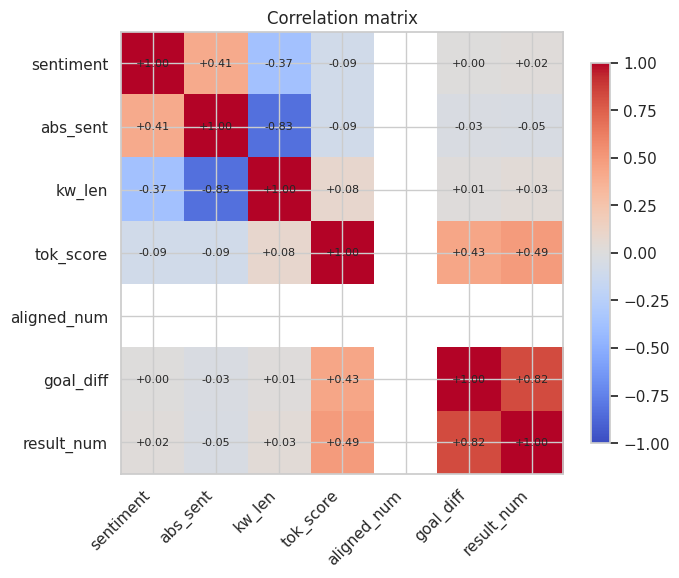

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from collections import Counter

MIN_APPEAR = 3
UNKNOWN_KEYWORDS = "<нет>"
HOME_COL, AWAY_COL = "HomeGoals", "AwayGoals"   # from matches_raw

#  News (linked) "keywords" column
news = linked.copy()
if "keywords" not in news.columns and "Слова-индикаторы" in news.columns:
    news.rename(columns={"Слова-индикаторы": "keywords"}, inplace=True)
news["keywords"] = news["keywords"].fillna(UNKNOWN_KEYWORDS).astype(str)

# Results (matches_raw)
home = (matches_raw
        .assign(team=matches_raw["HomeTeam"],
                opp = matches_raw["AwayTeam"],
                team_goals = matches_raw[HOME_COL],
                opp_goals  = matches_raw[AWAY_COL],
                venue="home")
        [["team","opp","team_goals","opp_goals","venue"]])

away = (matches_raw
        .assign(team=matches_raw["AwayTeam"],
                opp = matches_raw["HomeTeam"],
                team_goals = matches_raw[AWAY_COL],
                opp_goals  = matches_raw[HOME_COL],
                venue="away")
        [["team","opp","team_goals","opp_goals","venue"]])

matches_long = pd.concat([home, away], ignore_index=True)

# latest match per team (could swap to earliest or any other rule)
latest_match = (matches_long
                .drop_duplicates(subset="team", keep="last")
                .set_index("team"))

# news with score info
def fetch_latest_result(team: str):
    """Return team_goals, opp_goals for most recent match, else (NaN, NaN)."""
    if team in latest_match.index:
        r = latest_match.loc[team]
        return pd.Series([r.team_goals, r.opp_goals])
    return pd.Series([np.nan, np.nan])

news[["team_goals", "opp_goals"]] = news["team"].apply(fetch_latest_result)

# numeric coercion
news[["team_goals", "opp_goals"]] = news[["team_goals", "opp_goals"]].apply(
    pd.to_numeric, errors="coerce"
)

# keyword length
news["kw_len"] = (
    news["keywords"].str.count(",").fillna(0).astype(int)
    + (news["keywords"] != UNKNOWN_KEYWORDS).astype(int)
)

# goal difference from team’s perspective
news["goal_diff"] = news["team_goals"] - news["opp_goals"]

news["result_num"] = (
    news["goal_diff"].apply(lambda x: np.sign(x) if pd.notna(x) else pd.NA)
    .astype("Int8")
)

news["aligned_num"] = (
    news.get("has_influenced")
        .map({"W": 1, "L": -1})
        .astype("Int8")
)

# win/loss Stat
tok_win, tok_loss, tok_total = Counter(), Counter(), Counter()

for _, row in news.dropna(subset=["result_num"]).iterrows():
    toks = [t.strip() for t in row["keywords"].split(",")
            if t.strip() and t.strip() != UNKNOWN_KEYWORDS]
    tok_total.update(toks)
    if row["result_num"] == 1:
        tok_win.update(toks)
    elif row["result_num"] == -1:
        tok_loss.update(toks)

rows = []
for tok, total in tok_total.items():
    if total < MIN_APPEAR:
        continue
    w, l = tok_win[tok], tok_loss[tok]
    rows.append(dict(
        token = tok, appearances = total, wins = w, losses = l,
        win_rate = round(w/total, 3),
        loss_rate = round(l/total, 3),
        win_minus_loss = round((w-l)/total, 3)
    ))

if rows:
    tok_df = (pd.DataFrame(rows)
              .sort_values("win_minus_loss", ascending=False, na_position="last")
              .reset_index(drop=True))
else:
    print(f"No token met MIN_APPEAR = {MIN_APPEAR}.")
    tok_df = pd.DataFrame(columns=[
        "token","appearances","wins","losses",
        "win_rate","loss_rate","win_minus_loss"
    ])

print("\n=== Top tokens associated with wins vs losses ===")
print(tok_df.head(20).to_string(index=False))

# map token → win_minus_loss, default 0
tok_score_map = tok_df.set_index("token")["win_minus_loss"].to_dict()

def headline_token_score(kw: str) -> float:
    toks = [t.strip() for t in kw.split(",")
            if t.strip() and t.strip() != UNKNOWN_KEYWORDS]
    return float(np.mean([tok_score_map.get(t, 0) for t in toks])) if toks else 0.0

news["tok_score"] = news["keywords"].apply(headline_token_score)

#  Corr matrix (robust)
numeric_cols = ["sentiment","abs_sent","kw_len","tok_score",
                "aligned_num","goal_diff","result_num"]

news[numeric_cols] = news[numeric_cols].apply(pd.to_numeric, errors="coerce").astype(float)

# Keep rows that have at least TWO finite numbers (corr needs pairs)
corr_input = news[numeric_cols].dropna(thresh=2)

if corr_input.empty:
    print("Cannot build a correlation matrix")
    corr = pd.DataFrame(index=numeric_cols, columns=numeric_cols)
else:
    corr = corr_input.corr(min_periods=2).round(3)   # min_periods avoids NaNs from too-few pairs

print("\nCorrelation matrix (forced numeric)")
print(corr.fillna("").to_string())

# nice heat-map if we have anything meaningful
if corr_input.empty or corr.isna().all().all():
    print("\nNothing to plot – every correlation is NaN.")
else:
    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_xticks(range(len(corr)), labels=corr.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(corr)), labels=corr.index)
    for i in range(len(corr)):
        for j in range(len(corr)):
            ax.text(j, i, f"{corr.iat[i,j]:+.2f}" if pd.notna(corr.iat[i,j]) else "",
                    ha="center", va="center", fontsize=8)
    ax.set_title("Correlation matrix")
    fig.colorbar(im, shrink=0.8)
    plt.tight_layout()
    plt.show()



# **Comparison with Poisson**

This code scrapes detailed match data from the UEFA Champions League on soccer365.ru, including scores, statistics, and stadium info. It builds a structured dataset for analysis or machine learning, with support for resuming interrupted scrapes or loading a pre-saved snapshot from Dropbox. The final output is a clean CSV file with numeric values and enriched features like home advantage and attendance estimates.

In [ ]:
USE_DRIVE   = False
USE_DROPBOX = False
START_FROM  = 0

if USE_DRIVE:
    try:
        from google.colab import drive
        drive.mount("/content/drive", force_remount=False)
        DRIVE_ROOT = "/content/drive/MyDrive"
        print("Google Drive mounted ✓")
    except Exception:
        DRIVE_ROOT = "."
        print("Drive mount failed — saving locally")
else:
    DRIVE_ROOT = "."
    print("Google Drive disabled — saving locally")

import os, re, time, random, warnings, requests, unicodedata
import numpy as np, pandas as pd
from bs4 import BeautifulSoup as bs
warnings.filterwarnings("ignore")

COMP_ID = "19"
BASE    = "https://soccer365.ru"

SEASON_URLS = {
    "2024-2025": f"{BASE}/competitions/{COMP_ID}/results/",
    "2023-2024": f"{BASE}/competitions/{COMP_ID}/2023-2024/results/",
    "2022-2023": f"{BASE}/competitions/{COMP_ID}/2022-2023/results/",
    "2021-2022": f"{BASE}/competitions/{COMP_ID}/2021-2022/results/",
    "2020-2021": f"{BASE}/competitions/{COMP_ID}/2020-2021/results/",
    "2019-2020": f"{BASE}/competitions/{COMP_ID}/2019-2020/results/",
    "2018-2019": f"{BASE}/competitions/{COMP_ID}/2018-2019/results/",
}

SAVE_PATH   = os.path.join(DRIVE_ROOT, "final_uefa.csv")
DROPBOX_URL = ("https://www.dropbox.com/scl/fi/abcd1234abcd/final_uefa.csv"
               "?rlkey=xyz&dl=1")

HEADERS      = {"User-Agent": "Mozilla/5.0"}
STADIUMS_URL = f"{BASE}/competitions/{COMP_ID}/stadiums/"

STAT_COLS = [
    "xG","Удары","Удары в створ","Блок-но ударов","Сейвы","Владение %","Угловые",
    "Нарушения","Офсайды","Желтые карточки","Красные карточки","Атаки",
    "Опасные атаки","Передачи","Точность передач %","Штрафные удары",
    "Вбрасывания","Навесы"
]

# helpers
def _get(url, tries=3, pause=1):
    for a in range(tries):
        try:
            r = requests.get(url, headers=HEADERS, timeout=20); r.raise_for_status()
            return bs(r.content, "html.parser")
        except Exception:
            if a == tries-1: raise
            time.sleep(pause + random.random())

def all_match_links():
    """Unique list of match URLs from *all* SEASON_URLS."""
    links = set()
    for season, url in SEASON_URLS.items():
        print(f"Collecting links for {season} …")
        soup = _get(url)
        links.update(BASE + a["href"]
                     for a in soup.select("a.game_link[href]")
                     if "/games/" in a["href"])
    return sorted(links)

def safe_int(txt):
    if txt is None: return np.nan
    t = unicodedata.normalize("NFKD", txt).strip()
    return np.nan if t in {"", "-", "–"} else int(t)

def parse_match(url, idx, total):
    print(f"[{idx:04}/{total}] {url}")
    s  = _get(url)
    t1 = s.select_one("div.live_game.left  a").text.strip()
    g1 = safe_int(s.select_one("div.live_game.left  span").text)
    t2 = s.select_one("div.live_game.right a").text.strip()
    g2 = safe_int(s.select_one("div.live_game.right span").text)
    d  = dict(Команда_1=t1, Голы_1=g1, Команда_2=t2, Голы_2=g2, URL=url)

    for blk in s.select("div.stats_item"):
        title = blk.select_one("div.stats_title").text.strip()
        vals  = [float(re.sub(r"[^\d.\-]", "", x.text)) if x.text.strip() else np.nan
                 for x in blk.select("div.stats_inf")]
        d[f"{title}_1"], d[f"{title}_2"] = vals

    header = s.select_one("#game_events h2").text
    rnd  = re.search(r"(\d+)[\-\s]*тур", header, re.I) \
        or re.search(r"Раунд\s*(\d+)", header, re.I)
    d["Раунд"] = int(rnd.group(1)) if rnd else np.nan
    dt = re.search(r"\d{2}\.\d{2}\.\d{4}", header)
    tm = re.search(r"\d{2}:\d{2}", header)
    d["Дата"] = pd.to_datetime(dt.group(0), dayfirst=True) if dt else pd.NaT
    d["Время"] = tm.group(0) if tm else np.nan

    odds = s.select("table.adv_kef_wgt tr.adv_kef_wgt_odd td span.koeff")
    if odds: d["Кэф_1"], d["Кэф_х"], d["Кэф_2"] = [float(o.text) for o in odds[:3]]

    prev = s.select_one("#preview div.block_body")
    if prev:
        st = prev.select_one("div.preview_item.st")
        if st:
            a = st.select_one("a");    d["Стадион"] = a.text.strip() if a else np.nan
            t = st.select_one("div.img16.weath_tmp span.red")
            d["Градусы"] = t.text.strip() if t else np.nan
            w = st.select("span.min_gray")
            d["Погода"] = w[1].text.strip() if len(w) > 1 else np.nan
        for it in prev.select("div.preview_item"):
            if "Зрителей" in it.text:
                d["Зрители"] = int(re.sub(r"[^\d]", "", it.text)); break

    for k in ["Зрители","Погода","Градусы","Стадион","Кэф_1","Кэф_х","Кэф_2"]:
        d.setdefault(k, np.nan)
    for c in STAT_COLS:
        d.setdefault(f"{c}_1", np.nan); d.setdefault(f"{c}_2", np.nan)
    return d

# stadium helpers (unchanged from earlier snippet)
def stadium_table():
    s = _get(STADIUMS_URL)
    rows = []
    for tr in s.select("tr")[1:]:
        td = tr.find_all("td")
        if len(td) < 6: continue
        rows.append({"Стадион": td[1].a.text.strip(),
                     "Ссылка":  BASE+td[1].a["href"],
                     "Посещаемость": float(td[5].text.strip().replace(",",""))})
    return pd.DataFrame(rows)

def stadium_to_teams(link):
    return [a.text.strip() for a in _get(link).select("div.img16 a")]

def enrich(df):
    sd = stadium_table();  print("Parsing stadium pages …")
    sd["Команды"] = sd["Ссылка"].apply(stadium_to_teams)
    st2teams = sd.set_index("Стадион")["Команды"].to_dict()
    st2att   = sd.set_index("Стадион")["Посещаемость"].to_dict()

    df["Дома_1"] = df.apply(lambda r: int(r["Команда_1"] in st2teams.get(r["Стадион"], [])), axis=1)
    df["Дома_2"] = df.apply(lambda r: int(r["Команда_2"] in st2teams.get(r["Стадион"], [])), axis=1)
    def guess(row):
        if pd.isna(row["Зрители"]):
            base = st2att.get(row["Стадион"], np.nan)
            return np.nan if pd.isna(base) else int(base*(1+np.random.uniform(0.1,0.15)))
        return row["Зрители"]
    df["Зрители"] = df.apply(guess, axis=1);  return df

def download_csv(dest=SAVE_PATH):
    import subprocess
    print("Downloading snapshot …")
    subprocess.run(["wget","-q","-O",dest,DROPBOX_URL], check=True)

if USE_DROPBOX:
    if not os.path.exists(SAVE_PATH): download_csv()
    df = pd.read_csv(SAVE_PATH, sep=";")
    print(f"Loaded {len(df)} rows from snapshot.")
else:
    if os.path.exists(SAVE_PATH):
        print("Removing old CSV to scrape fresh …"); os.remove(SAVE_PATH)

    links = all_match_links()
    print(f"TOTAL links: {len(links)}")
    links = links[START_FROM:]
    recs  = []
    for i,u in enumerate(links, START_FROM+1):
        try:   recs.append(parse_match(u, i, START_FROM+len(links)))
        except Exception as e: print(f"⚠ Skip {u}: {e}")

    df = enrich(pd.DataFrame(recs))

    drop_cols = ["URL","Стадион","Атаки_1","Атаки_2","Опасные атаки_1","Опасные атаки_2"]
    df.drop(columns=drop_cols, inplace=True, errors="ignore")

    for stat in ["xG","Отборы","Передачи","Точность передач %","Навесы","Вбрасывания"]:
        for side in (1,2):
            col = f"{stat}_{side}"
            df[col] = df.groupby(f"Команда_{side}")[col].transform(lambda x: x.fillna(x.mean()))

    df["Таргет"] = np.select([df["Голы_1"]>df["Голы_2"], df["Голы_1"]<df["Голы_2"]],[1,2],0)
    df.to_csv(SAVE_PATH, sep=";", index=False)
    print(f"Scrape complete — saved {len(df)} rows to {SAVE_PATH}")

NON_NUM = {"Команда_1","Команда_2","Погода","Дата","Время"}
def to_num(x): return (np.nan if pd.isna(x)
                       else pd.to_numeric(re.sub(r"[^\d.\-]","",str(x)), errors="coerce"))
for c in df.columns:
    if df[c].dtype=="object" and c not in NON_NUM:
        df[c] = df[c].apply(to_num).astype(float)

print(f"DataFrame ready {df.shape[0]} rows × {df.shape[1]} cols")
df.head()


Google Drive disabled — saving locally
TOTAL links: 1528
[0001/1528] https://soccer365.ru/games/14111832/
[0002/1528] https://soccer365.ru/games/14111833/
[0003/1528] https://soccer365.ru/games/14111834/
[0004/1528] https://soccer365.ru/games/14111835/
[0005/1528] https://soccer365.ru/games/14111836/
[0006/1528] https://soccer365.ru/games/14111837/
[0007/1528] https://soccer365.ru/games/14111838/
[0008/1528] https://soccer365.ru/games/14111839/
[0009/1528] https://soccer365.ru/games/14111840/
[0010/1528] https://soccer365.ru/games/14111841/
[0011/1528] https://soccer365.ru/games/14111842/
[0012/1528] https://soccer365.ru/games/14111843/
[0013/1528] https://soccer365.ru/games/14111844/
[0014/1528] https://soccer365.ru/games/14111845/
[0015/1528] https://soccer365.ru/games/14111846/
[0016/1528] https://soccer365.ru/games/14111847/
[0017/1528] https://soccer365.ru/games/14111848/
[0018/1528] https://soccer365.ru/games/14111849/
[0019/1528] https://soccer365.ru/games/14111850/
[0020/1528] 

,Команда_1,Голы_1,Команда_2,Голы_2,Удары_1,Удары_2,Удары в створ_1,Удары в створ_2,Заблокированные удары_1,Заблокированные удары_2,...,Перехваты_2,Голевые моменты_1,Голевые моменты_2,Верховые дуэли_1,Верховые дуэли_2,Касания_1,Касания_2,Дома_1,Дома_2,Таргет
0,Санта-Колома,0.0,Дрита,2.0,10.0,23.0,3.0,10.0,7.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2
1,Ла Фиорита,0.0,Линкольн Ред Импс,2.0,7.0,13.0,1.0,6.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2
2,Линкольн Ред Импс,1.0,Дрита,4.0,10.0,16.0,3.0,9.0,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2
3,ТНС,4.0,Шкендия,0.0,14.0,10.0,7.0,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1
4,ХИК,3.0,Викингур Гота,1.0,17.0,5.0,9.0,3.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

Plotting correlation heat-map (target excluded)


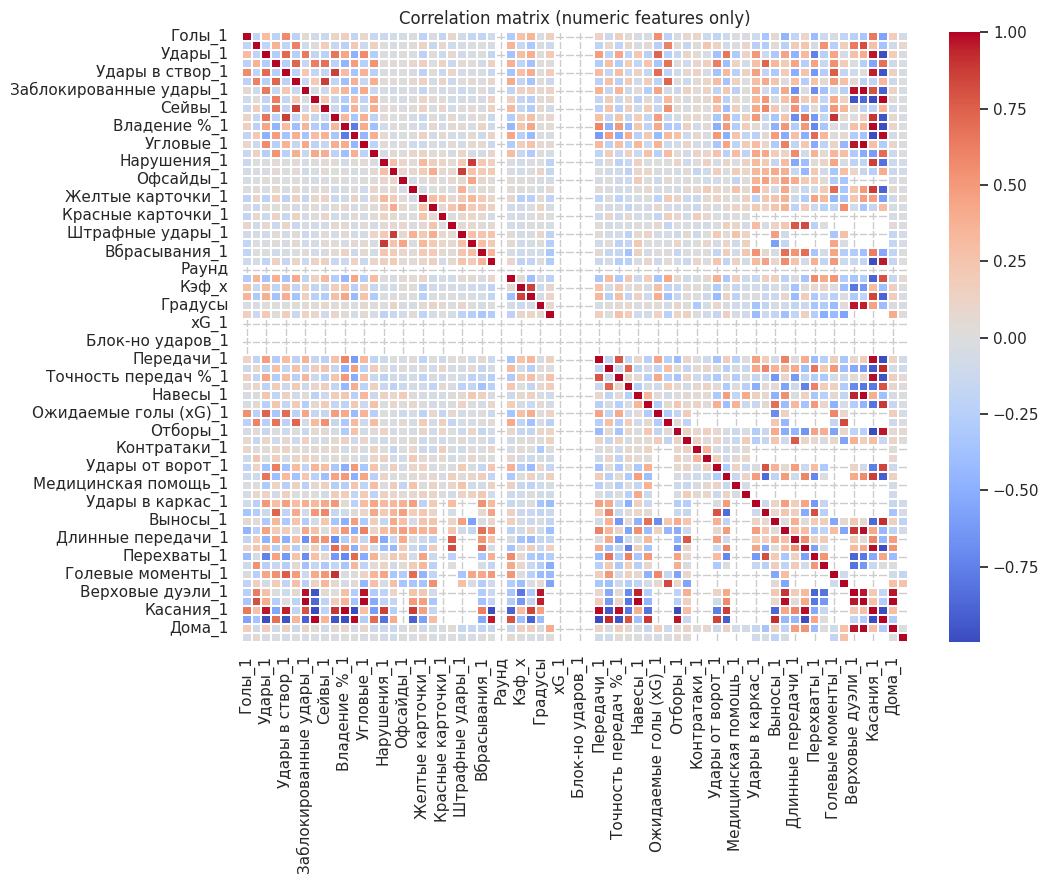


No severe leakage detected (|ρ| ≥ 0.8).

Training RandomForest on 68 features (leaks removed)

Classification report
              precision    recall  f1-score   support

        Draw       0.96      0.83      0.89        78
    Home win       0.97      0.99      0.98       183
    Away win       0.93      0.98      0.95       121

    accuracy                           0.95       382
   macro avg       0.95      0.93      0.94       382
weighted avg       0.95      0.95      0.95       382

Plotting top-10 feature importances


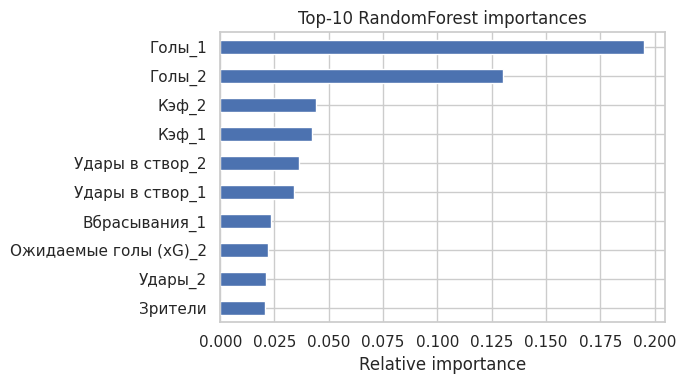


Top-10 importance values
Голы_1                  0.19511
Голы_2                  0.13028
Кэф_2                   0.04403
Кэф_1                   0.04236
Удары в створ_2         0.03646
Удары в створ_1         0.03386
Вбрасывания_1           0.02321
Ожидаемые голы (xG)_2   0.02200
Удары_2                 0.02095
Зрители                 0.02071


In [ ]:
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

NON_NUMERIC = {"Команда_1","Команда_2","Погода","Дата","Время"}
def to_num(x):
    if pd.isna(x): return np.nan
    return pd.to_numeric(re.sub(r"[^\d.\-]","",str(x)), errors="coerce")

for c in df.columns:
    if df[c].dtype=="object" and c not in NON_NUMERIC:
        df[c] = df[c].apply(to_num).astype(float)

# correlation matrix (target excluded)
numeric_df = df.select_dtypes(include=np.number).drop(columns=["Таргет"])
plt.figure(figsize=(11,9))
print("Plotting correlation heat-map (target excluded)")
sns.heatmap(numeric_df.corr(), cmap="coolwarm", linewidths=.3, center=0)
plt.title("Correlation matrix (numeric features only)")
plt.tight_layout()
plt.show()

# leakage probe
corr_with_target = df.select_dtypes(include=np.number).corr()["Таргет"].drop("Таргет")
leak_candidates  = corr_with_target[ corr_with_target.abs() >= 0.8 ].sort_values(key=np.abs, ascending=False)

if leak_candidates.empty:
    print("\nNo severe leakage detected (|ρ| ≥ 0.8).")
else:
    print("\nPotential leakage features (|ρ| ≥ 0.8):")
    print(leak_candidates.to_string(float_format="%.3f"))

# modelling (drop leak features if any)
feat_cols = numeric_df.columns.difference(leak_candidates.index)
print(f"\nTraining RandomForest on {len(feat_cols)} features")
X, y = df[feat_cols], df["Таргет"]
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rf.fit(Xtr, ytr)

print("\nClassification report")
print(classification_report(yte, rf.predict(Xte), target_names=["Draw","Home win","Away win"]))

# feature importances
imp = pd.Series(rf.feature_importances_, index=feat_cols).sort_values().tail(10)
plt.figure(figsize=(7,4))
print("Plotting top-10 feature importances")
imp.plot(kind="barh")
plt.xlabel("Relative importance")
plt.title("Top-10 RandomForest importances")
plt.tight_layout(); plt.show()

print("\nTop-10 importance values")
print(imp.sort_values(ascending=False).to_string(float_format="%.5f"))


🔍 Suspected leakage features:
['Голы_1', 'Голы_2']


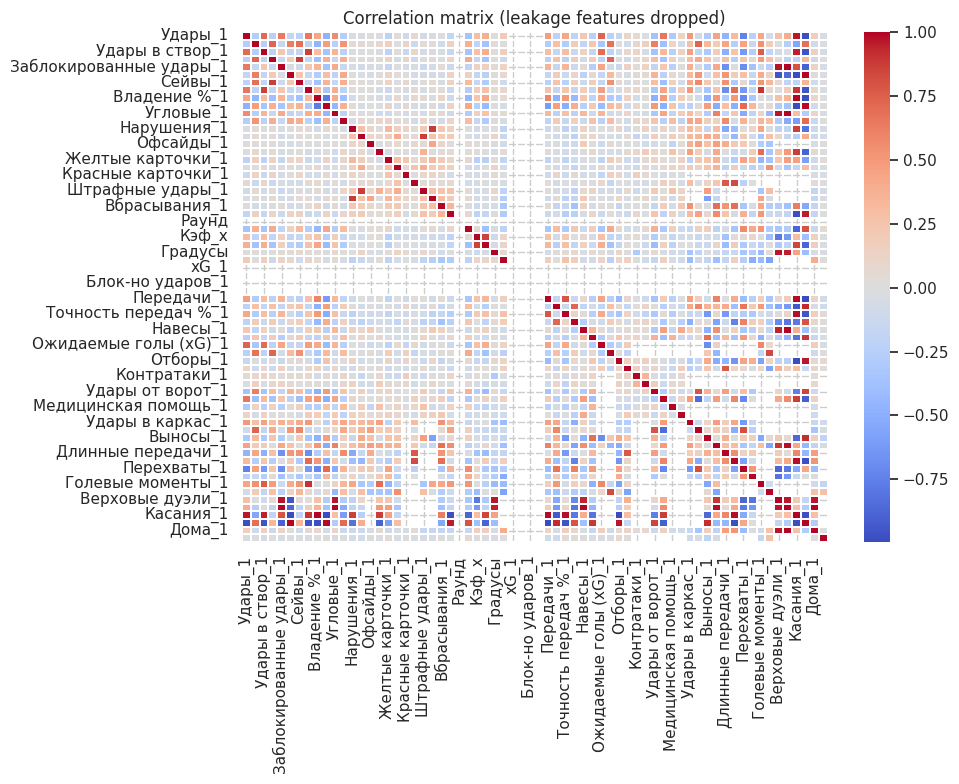

Training Random Forest …
Training Logistic Regression …
Training XGBoost …
Training SVM RBF …

📊 Model comparison after leakage removal:


,Accuracy,Precision,Recall,F1 Score
Model,,,,
Random Forest,0.9162,0.9301,0.8938,0.9059
XGBoost,0.9136,0.9098,0.8924,0.8977
Logistic Regression,0.5864,0.5007,0.5081,0.4933
SVM RBF,0.4791,0.1597,0.3333,0.2159


ValueError: Length of values (61) does not match length of index (66)

In [ ]:
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

NON_NUMERIC = {"Команда_1","Команда_2","Погода","Дата","Время"}
def to_num(x):
    if pd.isna(x): return np.nan
    return pd.to_numeric(re.sub(r"[^\d.\-]","",str(x)), errors="coerce")

for c in df.columns:
    if df[c].dtype=="object" and c not in NON_NUMERIC:
        df[c] = df[c].apply(to_num).astype(float)

#leakage detection
numeric_df = df.select_dtypes(include=np.number)
corr_target = numeric_df.corr()['Таргет'].drop('Таргет').abs().sort_values(ascending=False)

leak_cols = corr_target[corr_target > 0.8].index.tolist()
rule_based = [c for c in numeric_df.columns
              if re.match(r'Голы_\d', c) or c.startswith('goal_diff')]
leak_cols = sorted(set(leak_cols + rule_based))

print("Suspected leakage features:")
print(leak_cols if leak_cols else "— none found with |ρ| > 0.8")

# visualize correlations without leakage columns
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.drop(columns=leak_cols+['Таргет']).corr(),
            cmap='coolwarm', center=0, linewidths=.3)
plt.title("Correlation matrix (leakage features dropped)")
plt.tight_layout(); plt.show()


#  model training / evaluation
X = numeric_df.drop(columns=leak_cols + ['Таргет'])
y = numeric_df['Таргет'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.25, stratify=y, random_state=42)

models = {
    "Random Forest": make_pipeline(
        SimpleImputer(strategy='mean'),
        RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
    ),
    "Logistic Regression": make_pipeline(
        SimpleImputer(strategy='mean'),
        LogisticRegression(max_iter=1000, random_state=42)
    ),
    "XGBoost": make_pipeline(
        SimpleImputer(strategy='mean'),
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                      n_estimators=300, random_state=42)
    ),
    "SVM RBF": make_pipeline(
        SimpleImputer(strategy='mean'),
        SVC(random_state=42)
    )
}

results = []
for name, model in models.items():
    print(f"Training {name} …")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy":  accuracy_score (y_test, pred),
        "Precision": precision_score(y_test, pred, average='macro', zero_division=0),
        "Recall":    recall_score  (y_test, pred, average='macro', zero_division=0),
        "F1 Score":  f1_score      (y_test, pred, average='macro', zero_division=0)
    })

results_df = (pd.DataFrame(results)
              .set_index("Model")
              .round(4)
              .sort_values("F1 Score", ascending=False))

print("\nModel comparison after leakage removal:")
display(results_df)

# top importances for Rand Forest
rf = models["Random Forest"]
feat_imp = pd.Series(rf[-1].feature_importances_, index=X.columns)
top10 = feat_imp.sort_values().tail(10)

plt.figure(figsize=(7,4))
top10.plot(kind='barh')
plt.title("Top-10 RF importances (leaks removed)")
plt.xlabel("importance"); plt.tight_layout(); plt.show()


Plotting correlation heatmap


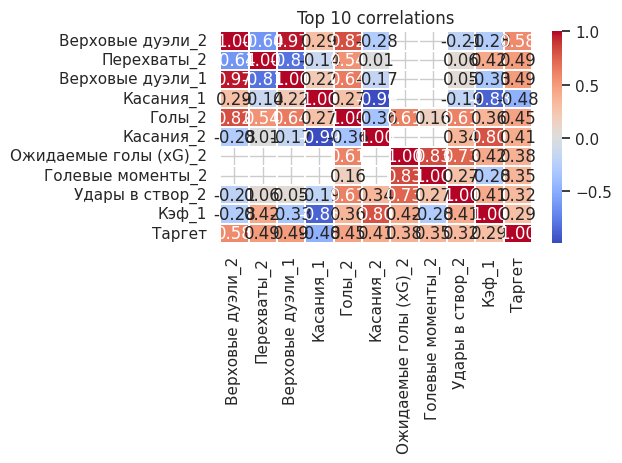

Training RandomForest
Classification report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        78
           1       0.97      0.99      0.98       183
           2       0.93      0.98      0.95       121

    accuracy                           0.95       382
   macro avg       0.95      0.93      0.94       382
weighted avg       0.95      0.95      0.95       382

Plotting feature importances


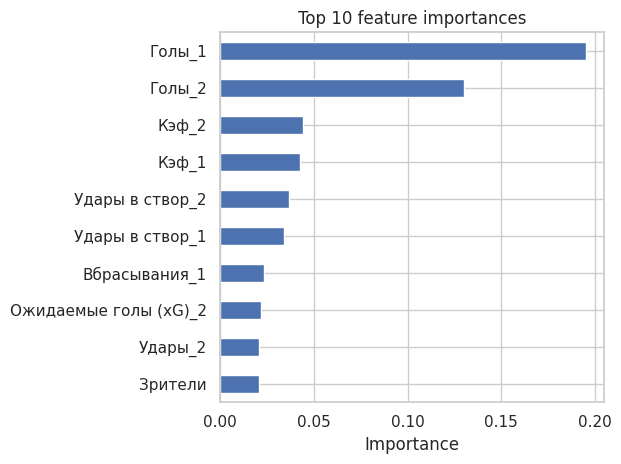

Importance values
Голы_1                  0.19511
Голы_2                  0.13028
Кэф_2                   0.04403
Кэф_1                   0.04236
Удары в створ_2         0.03646
Удары в створ_1         0.03386
Вбрасывания_1           0.02321
Ожидаемые голы (xG)_2   0.02200
Удары_2                 0.02095
Зрители                 0.02071


In [ ]:
NON_NUMERIC = {"Команда_1", "Команда_2", "Погода", "Дата", "Время"}

def to_num(x):
    if pd.isna(x):
        return np.nan
    return pd.to_numeric(re.sub(r"[^\d.\-]", "", str(x)), errors="coerce")

for c in df.columns:
    if df[c].dtype == "object" and c not in NON_NUMERIC:
        df[c] = df[c].apply(to_num).astype(float)

numeric_df = df.select_dtypes(include=np.number)

# delete 'Таргет' from cols
if 'Таргет' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['Таргет'])

corr_target = numeric_df.corrwith(df['Таргет']).abs().sort_values(ascending=False)
corr_cols = corr_target.head(10).index.tolist() + ["Таргет"]
print("Plotting correlation heatmap")
sns.heatmap(df[corr_cols].corr(), cmap="coolwarm", linewidths=.3, annot=True, fmt=".2f")
plt.title("Top 10 correlations")
plt.tight_layout()
plt.show()

num_cols = numeric_df.columns.tolist()  # list num values without Таргет

print("Training RandomForest")
X = numeric_df  #  без Таргет
y = df["Таргет"]

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rf.fit(Xtr, ytr)

# Prediction
y_pred = rf.predict(Xte)

print("Classification report")
print(classification_report(yte, y_pred))

imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values().tail(10)
print("Plotting feature importances")
imp.plot(kind="barh")
plt.xlabel("Importance")
plt.title("Top 10 feature importances")
plt.tight_layout()
plt.show()
print("Importance values")
print(imp.sort_values(ascending=False).to_string(float_format="%.5f"))

In [ ]:
# @title
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = rf.predict(Xte)

accuracy = accuracy_score(yte, y_pred)
precision = precision_score(yte, y_pred, average='weighted')
recall = recall_score(yte, y_pred, average='weighted')
f1 = f1_score(yte, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9529
Precision: 0.9532
Recall: 0.9529
F1-score: 0.9519


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

BERT-tokenising:   0%|          | 0/2064 [00:00<?, ?it/s]


=== Top BERT-tokens (wins vs losses) ===
    token  appearances  wins  losses  win_rate  loss_rate  win_minus_loss
       hf           14    14       0     1.000      0.000           1.000
   chance            3     3       0     1.000      0.000           1.000
    felix            3     3       0     1.000      0.000           1.000
       sg            3     3       0     1.000      0.000           1.000
      azi            3     3       0     1.000      0.000           1.000
  enrique            9     9       0     1.000      0.000           1.000
explained            3     3       0     1.000      0.000           1.000
     erik           19    19       0     1.000      0.000           1.000
   eduard            4     4       0     1.000      0.000           1.000
  opening            3     3       0     1.000      0.000           1.000
  florian            4     4       0     1.000      0.000           1.000
    molde            3     3       0     1.000      0.000           1.

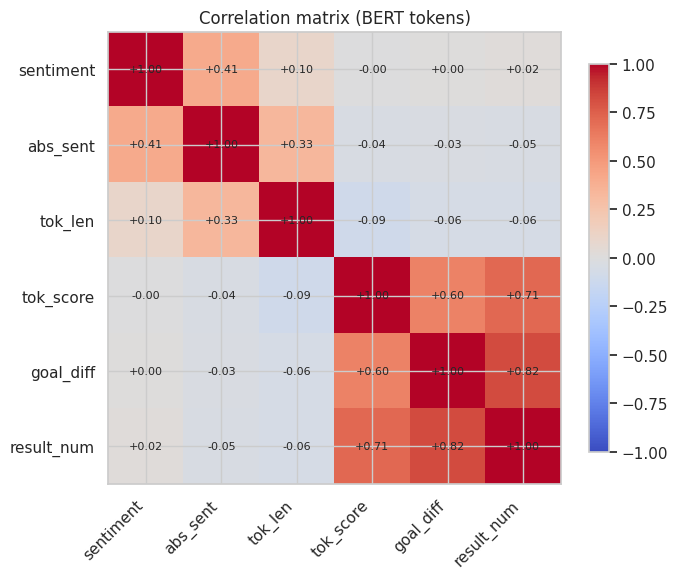

In [ ]:
# @title
import re, unicodedata, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from transformers import AutoTokenizer
from tqdm.auto import tqdm

MIN_APPEAR = 3
HOME_COL, AWAY_COL = "HomeGoals", "AwayGoals"   # из matches_raw

BERT_MODEL = "bert-base-multilingual-cased"
tokenizer  = AutoTokenizer.from_pretrained(BERT_MODEL)

def bert_words(text: str): #list of cleaned words

    toks = tokenizer.tokenize(text)
    out = []
    for tok in toks:
        tok = tok.lstrip("#").lower()
        tok = unicodedata.normalize("NFKD", tok)
        if re.fullmatch(r"[a-zа-я\d]{2,}", tok, re.I):
            out.append(tok)
    return out

news = linked.copy()
HEADLINE_COL = "title" if "title" in news.columns else news.columns[0]

# результаты long-формат
home = matches_raw.assign(team=matches_raw["HomeTeam"],
                          opp =matches_raw["AwayTeam"],
                          team_goals=matches_raw[HOME_COL],
                          opp_goals =matches_raw[AWAY_COL])
away = matches_raw.assign(team=matches_raw["AwayTeam"],
                          opp =matches_raw["HomeTeam"],
                          team_goals=matches_raw[AWAY_COL],
                          opp_goals =matches_raw[HOME_COL])
matches_long = pd.concat([home, away], ignore_index=True)[
    ["team","opp","team_goals","opp_goals"]
]

latest_match = (matches_long
                .drop_duplicates("team", keep="last")
                .set_index("team"))

def fetch_latest(team):
    if team in latest_match.index:
        r = latest_match.loc[team]
        return pd.Series([r.team_goals, r.opp_goals])
    return pd.Series([np.nan, np.nan])

news[["team_goals","opp_goals"]] = news["team"].apply(fetch_latest)
news[["team_goals","opp_goals"]] = news[["team_goals","opp_goals"]].apply(
    pd.to_numeric, errors="coerce"
)

#  BERT token list
tqdm.pandas(desc="BERT-tokenising")
news["bert_tokens"] = news[HEADLINE_COL].astype(str).progress_apply(bert_words)


news["tok_len"]   = news["bert_tokens"].apply(len)
news["goal_diff"] = news["team_goals"] - news["opp_goals"]
news["result_num"]= (news["goal_diff"]
                     .apply(lambda x: np.sign(x) if pd.notna(x) else pd.NA)
                     .astype("Int8"))

# win/loss stats
tok_win, tok_loss, tok_total = Counter(), Counter(), Counter()

for _, r in news.dropna(subset=["result_num"]).iterrows():
    toks = r["bert_tokens"]
    tok_total.update(toks)
    if r["result_num"] == 1:  tok_win.update(toks)
    elif r["result_num"]==-1: tok_loss.update(toks)

rows=[]
for tok, tot in tok_total.items():
    if tot < MIN_APPEAR: continue
    w, l = tok_win[tok], tok_loss[tok]
    rows.append(dict(token=tok,appearances=tot,wins=w,losses=l,
                     win_rate=round(w/tot,3),
                     loss_rate=round(l/tot,3),
                     win_minus_loss=round((w-l)/tot,3)))
tok_df = (pd.DataFrame(rows)
          .sort_values("win_minus_loss",ascending=False,na_position="last")
          .reset_index(drop=True))

print("\n=== Top BERT-tokens (wins vs losses) ===")
print(tok_df.head(20).to_string(index=False))

tok_score_map = tok_df.set_index("token")["win_minus_loss"].to_dict()
def headline_tok_score(toks):
    return float(np.mean([tok_score_map.get(t,0) for t in toks])) if toks else 0.0
news["tok_score"] = news["bert_tokens"].apply(headline_tok_score)

#  correlation
num_cols = ["sentiment","abs_sent","tok_len","tok_score","goal_diff","result_num"]
news[num_cols] = news[num_cols].apply(pd.to_numeric, errors="coerce").astype(float)
corr_input = news[num_cols].dropna(thresh=2)
corr = (corr_input.corr(min_periods=2).round(3)
        if not corr_input.empty else
        pd.DataFrame(index=num_cols, columns=num_cols))

print("\n=== Correlation matrix (BERT) ===")
print(corr.fillna("").to_string())

if not corr_input.empty and not corr.isna().all().all():
    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_xticks(range(len(corr)), labels=corr.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(corr)), labels=corr.index)
    for i in range(len(corr)):
        for j in range(len(corr)):
            txt = "" if pd.isna(corr.iat[i,j]) else f"{corr.iat[i,j]:+.2f}"
            ax.text(j, i, txt, ha="center", va="center", fontsize=8)
    ax.set_title("Correlation matrix (BERT tokens)")
    fig.colorbar(im, shrink=0.8)
    plt.tight_layout(); plt.show()
else:
    print("\n correlation matrix empty.")
